# <center>ECEN 758 Data Mining and Analysis Project - Fall 2023<center>
<center>Developed by Team Jarvis <center>
<center>Team Members: Ching-Yao, Harika, Arun<center>

# 1. Project Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# Machine learning
from keras.datasets import fashion_mnist
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
#from skopt import BayesSearchCV
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Deep learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

# Housekeepings
from tqdm import tqdm
import os
import random
import pickle
import itertools
from collections import namedtuple
from joblib import load

# Notebook Setups
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)

In [3]:
# Helper functions
def print_colored_text(text, background_color="white", font_color="black", bold=False):
    font_weight = "bold" if bold else "normal"
    html_code = f'<div style="background-color: {background_color}; color: {font_color}; font-weight: {font_weight}; padding: 10px; display: inline-block;">{text}</div>'
    display(HTML(html_code))

def set_seed(seed: int = 42) -> None:
    """Set random seeds for used packages"""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
# Set the root directory
root_dir = "/content/drive/Shareddrives/ECEN758 Group Jarvis/Colab Notebooks/"

# Set up the device for pytorch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Set a common random seed for all packages
SEED = 42
set_seed(SEED)

cuda:0


# 2. Exploratory Data Analysis (EDA)

## 2.1 Descriptive statistics

In [5]:
# Load Fashion MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
# Flatten each image in X_train
flattened_X_train = X_train.reshape(X_train.shape[0], -1)

# Count unique number of labels in y_train
unique_labels, counts = np.unique(y_train, return_counts=True)
label_counts = dict(zip(unique_labels, counts))
print("Number of unique labels:", len(unique_labels))
print("Number of data points under each label:", label_counts)
print("\n" + "="*40 + "\n")

# Descriptive statistics (e.g., class distributions, data statistics)
class_distribution = pd.Series(y_train).value_counts().sort_index()
print("Class Distribution:\n")
display(class_distribution)
print("\n" + "="*40 + "\n")

Number of unique labels: 10
Number of data points under each label: {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}


Class Distribution:



0    6000
1    6000
2    6000
3    6000
4    6000
5    6000
6    6000
7    6000
8    6000
9    6000
dtype: int64

In [7]:
# Create a DataFrame for flattened_X_train
flattened_X_train_df = pd.DataFrame(flattened_X_train)

# Display data statistics
data_statistics = flattened_X_train_df.describe()
print("Data Statistics:\n")
display(data_statistics)
print("\n" + "="*40 + "\n")

# Calculate mean, median, and standard deviation for each image
image_means = np.mean(X_train, axis=(1, 2))
image_medians = np.median(X_train, axis=(1, 2))
image_std_devs = np.std(X_train, axis=(1, 2))

Data Statistics:



0             1             2             3             4    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.000800      0.005783      0.030083      0.103800      0.249683   
std        0.092554      0.249033      0.767868      2.512017      4.331376   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max       16.000000     36.000000    119.000000    164.000000    224.000000   

                5             6             7             8             9    \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.414717      0.821667      2.224733      5.698667     14.434650   
std        5.827394      8.309935     14.201820     23.835980     38.204702   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      230.000000    221.000000    221.000000    254.000000    255.000000   

                10            11            12            13            14   \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      32.955950     45.918567     52.092600     50.870583     50.522867   
std       57.762681     66.161902     68.645664     67.931463     67.453509   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%       49.000000     91.000000    106.000000    103.000000    102.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

                15            16            17            18            19   \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      53.906417     51.527283     40.653267     26.119367     10.408617   
std       69.541488     68.016799     62.842361     51.783496     32.534108   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%      109.000000    103.000000     78.000000     21.000000      0.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

                20            21            22            23            24   \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.108633      1.979683      1.181317      0.850300      0.476850   
std       20.204783     14.118429     10.757762      9.219995      6.984142   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      251.000000    255.000000    233.000000    232.000000    239.000000   

                25            26            27            28           29   \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.00000   
mean       0.260267      0.097650      0.016817      0.007117      0.02405   
std        5.152126      2.934722      1.234501      0.566072      1.34649   
min        0.000000      0.000000      0.000000      0.000000      0.00000   
25%        0.000000      0.000000      0.000000      0.000000     

In [8]:
# Create a DataFrame to display the statistics
image_statistics = pd.DataFrame({
    'Mean': image_means,
    'Median': image_medians,
    'Std Dev': image_std_devs
})

print("Image Statistics:\n")
display(image_statistics)
print("\n" + "="*40 + "\n")


Image Statistics:



Mean  Median     Std Dev
0       97.253827    44.0  101.792346
1      107.905612   110.0  100.831448
2       36.558673     0.0   49.698752
3       59.501276    14.0   64.849295
4       78.044643     0.0  103.843248
...           ...     ...         ...
59995   26.738520     0.0   55.254691
59996   54.542092     0.0   93.039153
59997   79.778061     0.0  107.510829
59998   42.742347    57.0   38.508645
59999   21.280612     0.0   48.536572

[60000 rows x 3 columns]

In [9]:
### Pixel Intensity Profiles:
# Calculate pixel intensity profiles along different axes
horizontal_profiles = np.mean(X_train, axis=1).mean(axis=1)
vertical_profiles = np.mean(X_train, axis=2).mean(axis=1)

# Create a DataFrame to display the profiles
pixel_profiles = pd.DataFrame({
    'Horizontal Profile': horizontal_profiles,
    'Vertical Profile': vertical_profiles
})

print("Pixel Intensity Profiles:\n")
display(pixel_profiles)
print("\n" + "="*40 + "\n")

Pixel Intensity Profiles:



Horizontal Profile  Vertical Profile
0               97.253827         97.253827
1              107.905612        107.905612
2               36.558673         36.558673
3               59.501276         59.501276
4               78.044643         78.044643
...                   ...               ...
59995           26.738520         26.738520
59996           54.542092         54.542092
59997           79.778061         79.778061
59998           42.742347         42.742347
59999           21.280612         21.280612

[60000 rows x 2 columns]

In [10]:
### Outlier Detection

# Identify outliers based on pixel intensity (e.g., using Z-score)
z_scores = (X_train.flatten() - np.mean(X_train.flatten())) / np.std(X_train.flatten())
outliers = np.where(np.abs(z_scores) > 3)

print("Number of outliers:", len(outliers[0]))
print("\n" + "="*40 + "\n")

Number of outliers: 0




## 2.2 Data visualization

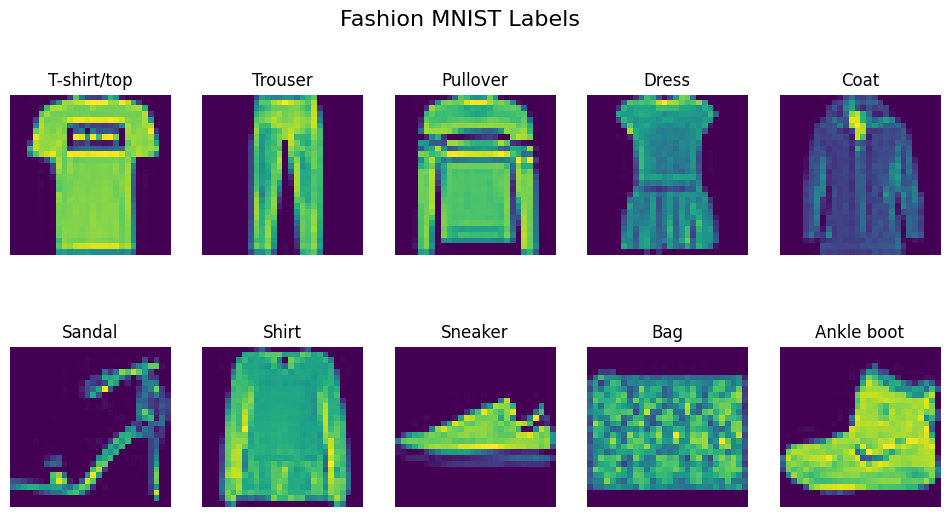

In [11]:
# Mapping of label indices to label names
label_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# Display one image for each label in black and white
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
_ = fig.suptitle("Fashion MNIST Labels", fontsize=16)

for label in range(10):
    # Find the index of the first image with the given label
    index = np.where(y_train == label)[0][0]

    # Reshape the image to 28x28
    image = X_train[index].reshape(28, 28)

    # Display the image in black and white
    _ = axs[label // 5, label % 5].imshow(image, cmap="viridis")
    _ = axs[label // 5, label % 5].set_title(label_mapping[label])
    _ = axs[label // 5, label % 5].axis("off")

plt.show();

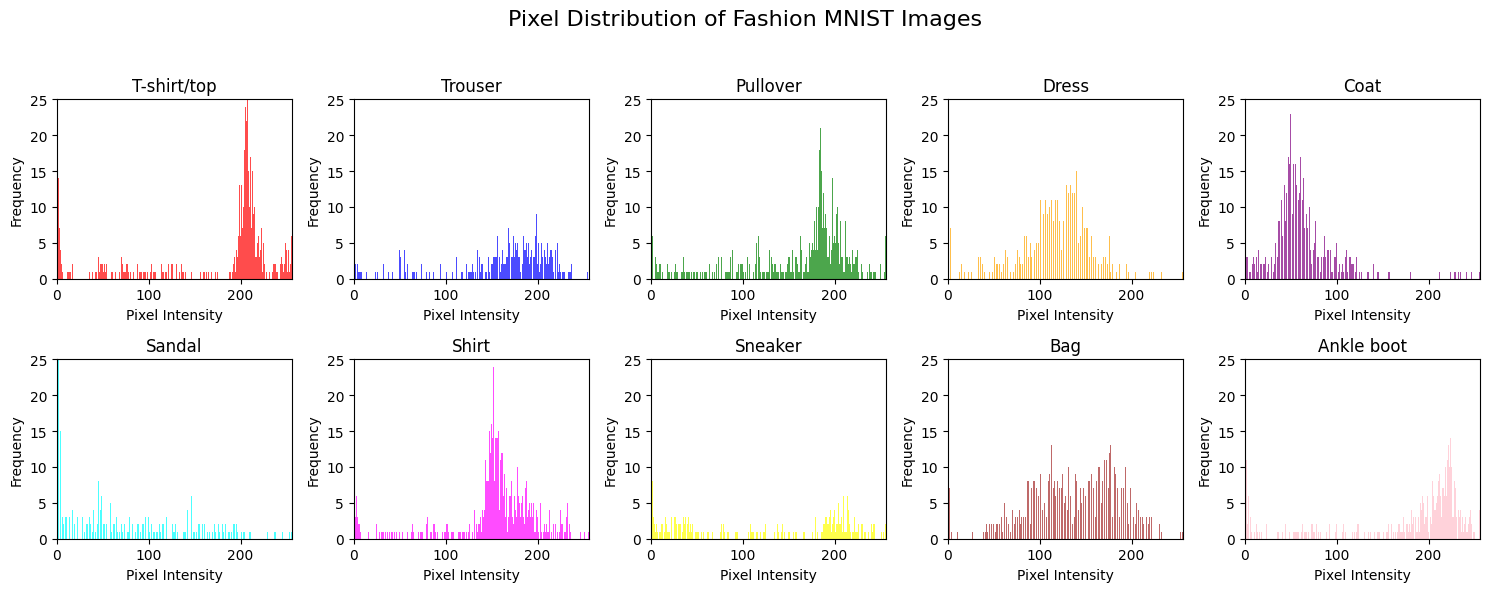

In [12]:
# Define a list of colors for histograms
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'brown', 'pink']

# Create a 2x5 grid for subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
_ = fig.suptitle("Pixel Distribution of Fashion MNIST Images", fontsize=16)

# Display pixel distribution for each label in a single graph
for label in range(10):
    # Find the index of the first image with the given label
    index = np.where(y_train == label)[0][0]

    # Reshape the image to 28x28
    image = X_train[index].reshape(28, 28)

    # Flatten the image to a 1D array for histogram
    pixel_values = image.flatten()

    # Plot the pixel distribution histogram with different colors
    _ = axs[label // 5, label % 5].hist(pixel_values, bins=256, range=(0, 256), color=colors[label], alpha=0.7)
    _ = axs[label // 5, label % 5].set_title(label_mapping[label])
    _ = axs[label // 5, label % 5].set_xlabel("Pixel Intensity")
    _ = axs[label // 5, label % 5].set_ylabel("Frequency")
    _ = axs[label // 5, label % 5].set_xlim([0, 256])
    _ = axs[label // 5, label % 5].set_ylim([0, 25])  # Set y-axis limit to 50

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show();

Explained variation per principal component: [0.29039228 0.1775531  0.06019222]


        PC1       PC2       PC3  label
0 -0.486250  6.404213 -4.749181      9
1  5.521290 -1.771142 -1.023635      0
2 -2.846709 -4.320934  0.416291      0
3  0.123132 -3.847324  0.794435      3
4  3.153409 -4.710466 -2.919126      0




Text(0.5, 0.98, '3-Component PCA')

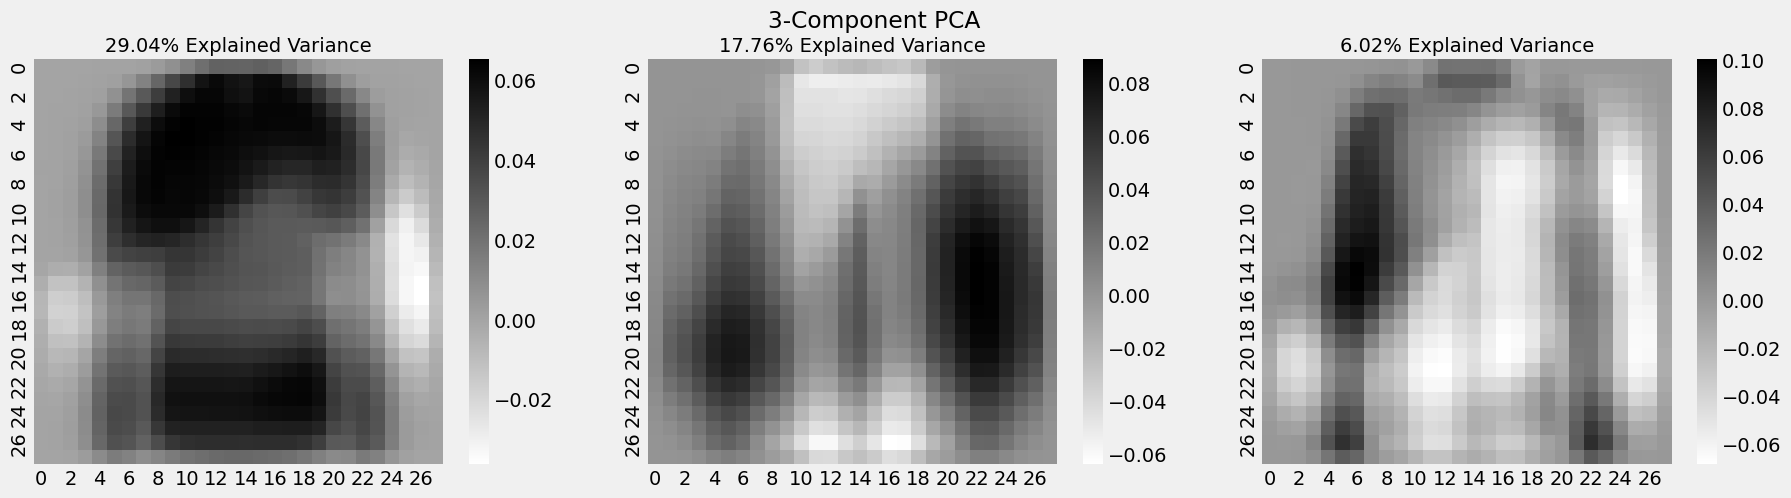

In [13]:
# Flatten the images and scale pixel values
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0

# Implement Principal Component Analysis (PCA)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train_flat)

# Explained variation per principal component
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variation per principal component:", explained_variance_ratio)
print("\n" + "="*40 + "\n")

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = y_train

# Preview the first few rows in the `pca_df` DataFrame
print(pca_df.head())
print("\n" + "="*40 + "\n")

# Set the graph style as 'fivethirtyeight'
plt.style.use('fivethirtyeight')

# Set figure size
fig, axarr = plt.subplots(1, 3, figsize=(20, 5))

# use seaborn heatmap to visualize the first three pca components
_ = sns.heatmap(pca.components_[0, :].reshape(28, 28), ax=axarr[0], cmap=plt.cm.binary)
_ = sns.heatmap(pca.components_[1, :].reshape(28, 28), ax=axarr[1], cmap=plt.cm.binary)
_ = sns.heatmap(pca.components_[2, :].reshape(28, 28), ax=axarr[2], cmap=plt.cm.binary)

# Set picture title to explained variance
_ = axarr[0].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100), fontsize=14)
_ = axarr[1].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100), fontsize=14)
_ = axarr[2].set_title("{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100), fontsize=14)

# Add picture title
plt.suptitle('3-Component PCA')

# Show the plots
plt.show();
print("\n" + "="*40 + "\n")


<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'n_components')

Text(0, 0.5, 'Cumulative_Explained_Variance')

Text(0.5, 1.0, 'PCA Spectrum')

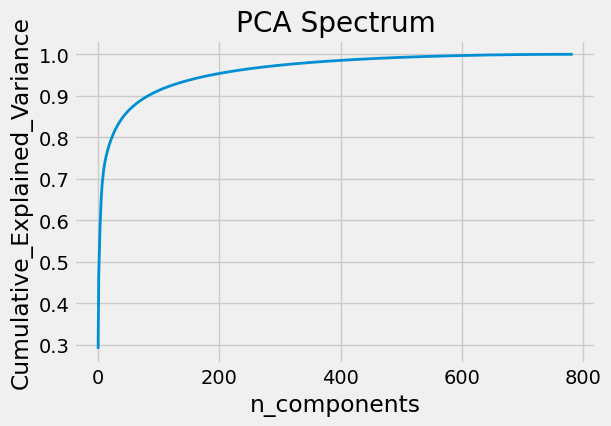

<Figure size 1200x750 with 0 Axes>

<Axes: xlabel='First Dimension', ylabel='Second Dimension'>

Text(0.5, 1.0, '2D PCA Visualization')

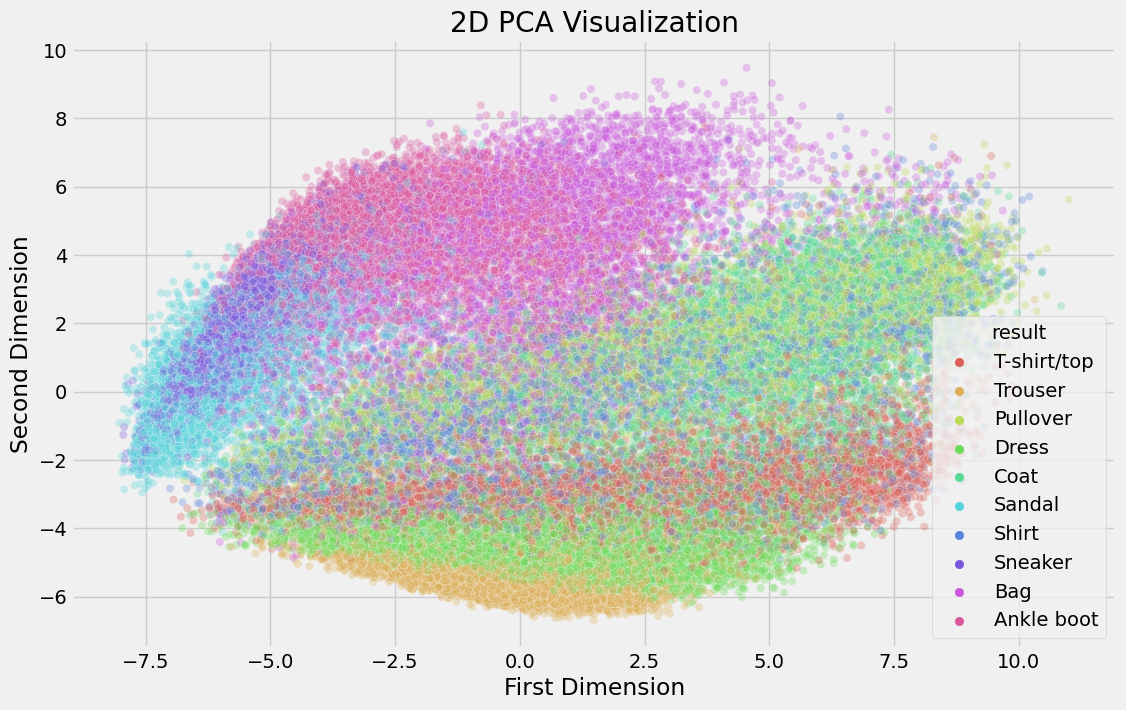

Text(0.5, 0, 'First Dimension')

Text(0.5, 0.5, 'Second Dimension')

Text(0.5, 0, 'Third Dimension')

Text(0.5, 0.92, '3D PCA Visualization')

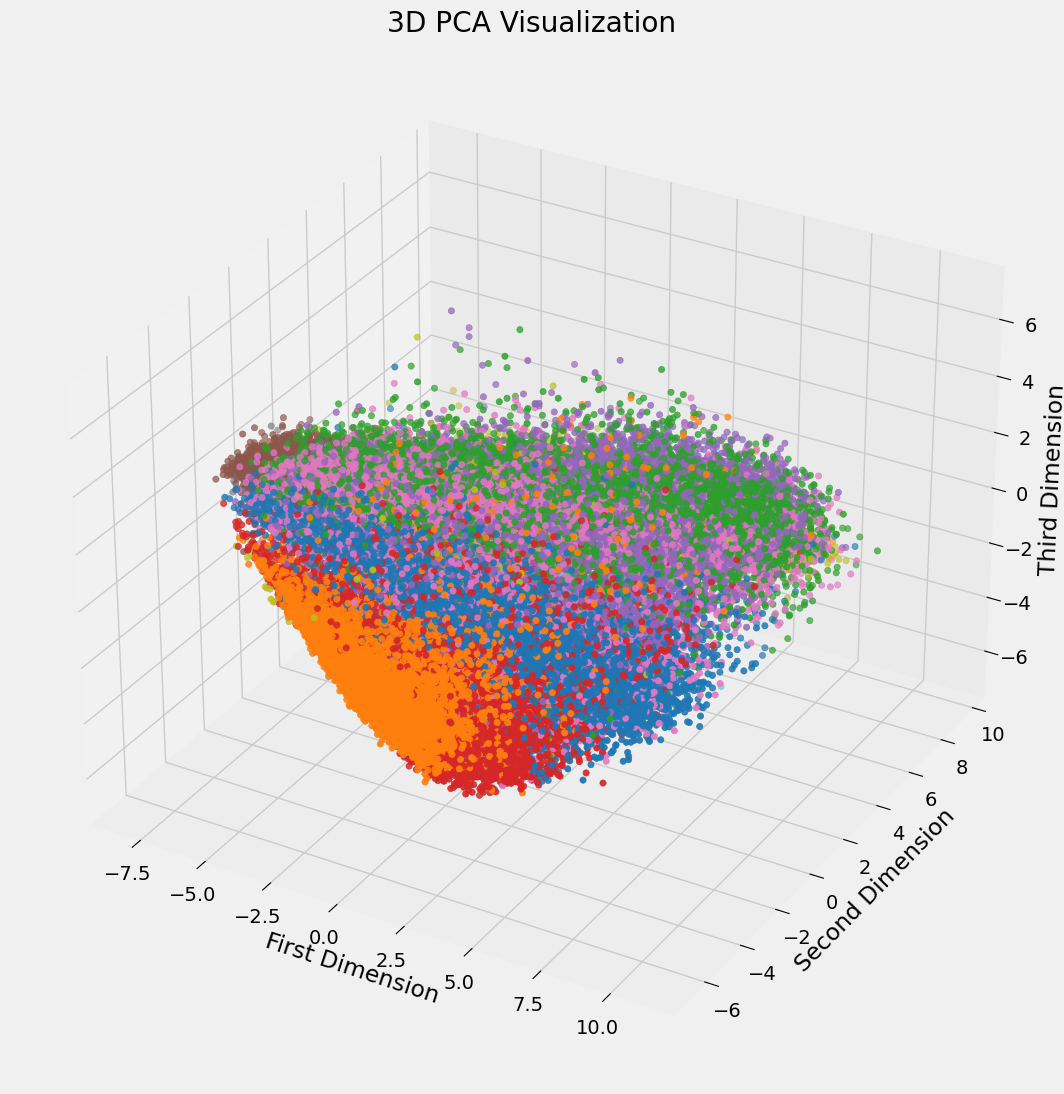

In [14]:
# initializing the pca
# Set n_components as 784 dimensions
pca = PCA(n_components=784)
# Fit on training data
pca_784 = pca.fit_transform(X_train_flat)

# Plot the PCA spectrum
plt.figure(figsize=(6, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), linewidth=2)
plt.xlabel("n_components")
plt.ylabel("Cumulative_Explained_Variance")
plt.title('PCA Spectrum')
# Show the plot
plt.show();
print("\n" + "="*40 + "\n")

# Create a DataFrame with PCA results (including the first 3 components)
pca_df = pd.DataFrame(data=pca_784[:, :3], columns=['First Dimension', 'Second Dimension', 'Third Dimension'])
pca_df['label'] = y_train
pca_df['result'] = pca_df['label'].map({
    0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
    5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'
})

# Plot 2D PCA
plt.figure(figsize=(12, 7.5))
sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue="result",
    hue_order=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'],
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)
plt.title('2D PCA Visualization')
# Show the plot
plt.show();
print("\n" + "="*40 + "\n")

# Plot 3D PCA
fig = plt.figure(figsize=(12, 15))  # Adjust the figsize for the 3D plot
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create a 3D subplot
ax.scatter(
    xs=pca_df["First Dimension"],
    ys=pca_df["Second Dimension"],
    zs=pca_df["Third Dimension"],
    c=pca_df["label"],
    cmap='tab10'
)
ax.set_xlabel('First Dimension')
ax.set_ylabel('Second Dimension')
ax.set_zlabel('Third Dimension')
plt.title('3D PCA Visualization')
# Show the plot
plt.show();
print("\n" + "="*40 + "\n")



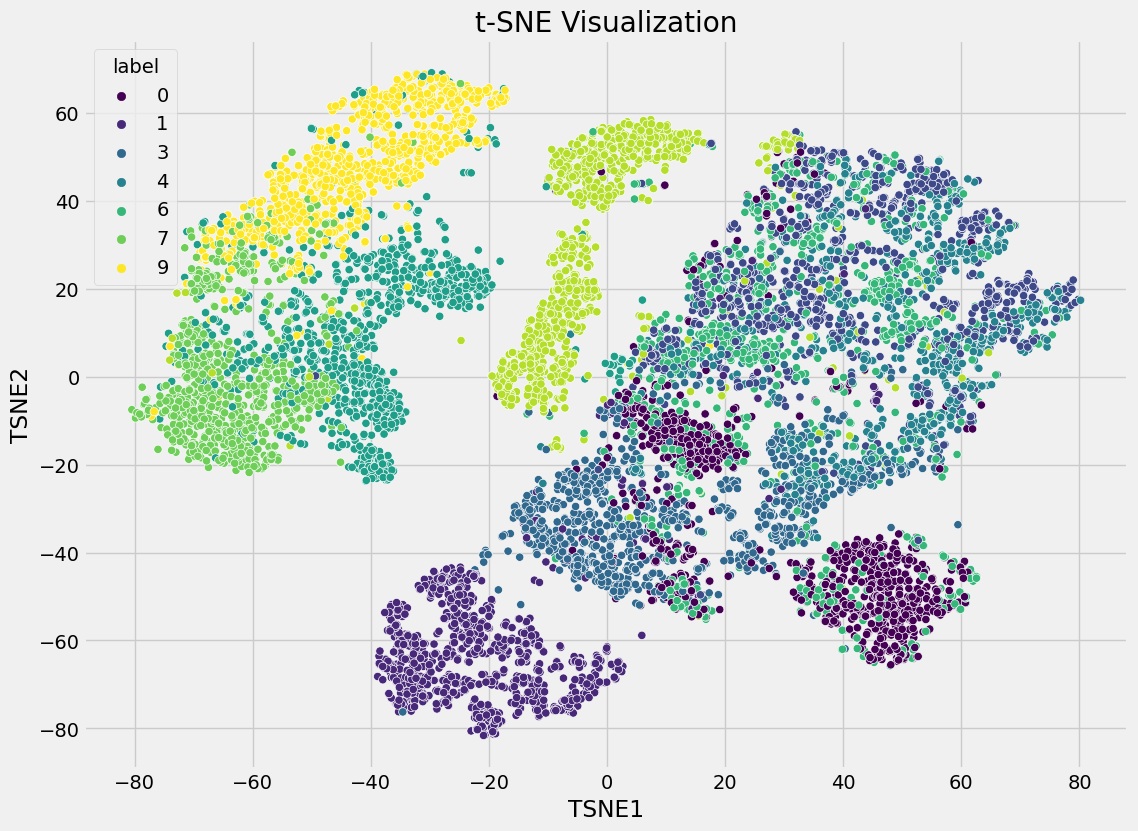

In [15]:
# Visualize using t-Distributed Stochastic Neighbouring Entities (t-SNE)
# Create a random generator to decrease potential biases in the data
np.random.seed(42)

# Pull 10000 pictures out of the sample
random_indices = np.random.choice(X_train_flat.shape[0], 10000, replace=False)
X_subset = X_train_flat[random_indices]
y_subset = y_train[random_indices]

# Run t-SNE algorithm
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X_subset)

# Create a DataFrame with t-SNE results
tsne_df = pd.DataFrame(data=tsne_result, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = y_subset

# Display the analysis results in a two-dimensional chart
plt.figure(figsize=(12, 9))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='label', data=tsne_df, palette='viridis')
plt.title('t-SNE Visualization')
# Show the plot
plt.show();

# 3. Data Preparation


In [16]:
# Flatten the images and scale pixel values to mean=0.0 and var=1.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_train= (X_train - np.mean(X_train)) / np.std(X_train)

# Flatten the images and scale pixel values to mean=0.0 and var=1.0
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [17]:
#Cross Validation split
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
data_splits = stratified_kfold.split(X=X_train, y=y_train)

# 4. Model building

## 4.1 Random Forest Classifier

### 4.1.1 Default Random Forest Classifier

In [18]:
#Flattening each input image
X_train_flat = X_train.reshape(X_train.shape[0], 28*28)
X_test_flat = X_test.reshape(X_test.shape[0], 28*28)

#Normalizing
X_train_normalized = X_train_flat/255
X_test_normalized = X_test_flat/255

# Print the dimensions of the dataset after normalizing
print('Train: X = ', X_train_normalized.shape)
print('Test: X = ', X_test_normalized.shape)

#cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Train: X =  (60000, 784)
Test: X =  (10000, 784)


In [19]:
# Print the dimensions of the dataset after normalizing
print('Train: X = ', X_train_normalized.shape)
print('Test: X = ', X_test_normalized.shape)

Train: X =  (60000, 784)
Test: X =  (10000, 784)


In [20]:
# Create a RandomForestClassifier object
default_model = RandomForestClassifier(random_state=42)

In [21]:
# Fit the model on the entire training set
default_model.fit(X_train_normalized, y_train)

RandomForestClassifier(random_state=42)

Evaluation for Default Random Forest:



Random Forest model with default parameters:

Test Accuracy: 87.60%
Precision: 0.8749
Recall: 0.8760
F1-Score: 0.8745


Confusion Matrix:


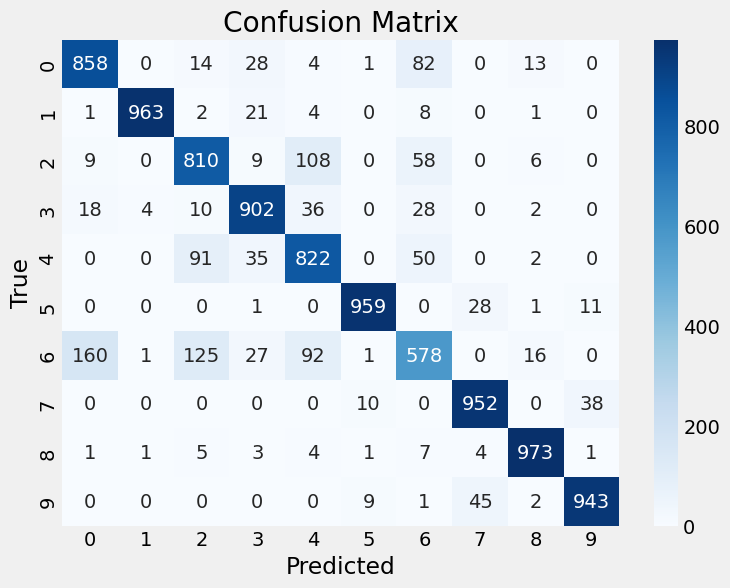

In [22]:
# Evaluate the default random forest
print("Evaluation for Default Random Forest:")

y_test_pred = default_model.predict(X_test_normalized)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\nRandom Forest model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show();

### 4.1.2 HyperParameter Tuning


```python
### Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=SEED)

### Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100],
    'max_depth': [20,50],
    'min_samples_split': [2,4],
    'min_samples_leaf': [1,2]
}

grid_search = GridSearchCV(
    rf_classifier,
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='accuracy',  # Accuracy as metric
    verbose=10,  # Adjust verbosity level (0 for no output, higher integers for more details)
)

grid_search.fit(X_train_normalized, y_train)

###Access the grid search results
grid_results = grid_search.cv_results_

### Create a DataFrame to store the results
grid_results_df = pd.DataFrame({
    'Mean Score': grid_results['mean_test_score'],
    'Std Dev Score': grid_results['std_test_score'],
    'Params': grid_results['params']
})

grid_results_df = grid_results_df.sort_values(by='Mean Score', ascending=False)
header = ["Index", "Mean Score", "Std Dev Score", "Params"]
grid_results_df.index.name = "Index"
grid_results_df.reset_index(inplace=True)

### Display the grid search results
print(grid_results_df.to_markdown(headers=header, index=False))
print("\n" + "="*40 + "\n")

### Print the best hyperparameters
best_params_rf = grid_search.best_params_
print("Best Hyperparameters (Random Forest):", best_params_rf)
```


```
# Train the model on the whole training set using the best hyperparameters
best_model = grid_search.best_estimator_
```

```
def train_classifiers(estimator, X_train, y_train, cv, name):
    # Initialize lists to store metrics for each fold
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Train the model on the training fold
        estimator.fit(X_train_fold, y_train_fold)

        # Make predictions on the validation fold
        y_val_pred = estimator.predict(X_val_fold)

        # Calculate metrics for the current fold
        accuracy_fold = accuracy_score(y_val_fold, y_val_pred)
        precision_fold = precision_score(y_val_fold, y_val_pred, average='weighted')
        recall_fold = recall_score(y_val_fold, y_val_pred, average='weighted')
        f1_fold = f1_score(y_val_fold, y_val_pred, average='weighted')

        # Append metrics to the lists
        accuracy_list.append(accuracy_fold)
        precision_list.append(precision_fold)
        recall_list.append(recall_fold)
        f1_list.append(f1_fold)

        # Print metrics for the current fold
        print(f"Fold {fold + 1} - {name} model:")
        print(f"  - Accuracy: {accuracy_fold * 100:.2f}%")
        print(f"  - Precision: {precision_fold:.4f}")
        print(f"  - Recall: {recall_fold:.4f}")
        print(f"  - F1-Score: {f1_fold:.4f}")
        print("\n" + "="*40 + "\n")

    # Calculate and print average metrics across all folds
    avg_accuracy = sum(accuracy_list) / len(accuracy_list)
    avg_precision = sum(precision_list) / len(precision_list)
    avg_recall = sum(recall_list) / len(recall_list)
    avg_f1 = sum(f1_list) / len(f1_list)

    print(f"Average {name} model metrics across all folds:")
    print(f"  - Average Accuracy: {avg_accuracy * 100:.2f}%")
    print(f"  - Average Precision: {avg_precision:.4f}")
    print(f"  - Average Recall: {avg_recall:.4f}")
    print(f"  - Average F1-Score: {avg_f1:.4f}")
    print("\n" + "="*40 + "\n")
```

```
# Use the train_classifiers function to print cross-fold metrics
train_classifiers(best_model, X_train_normalized, y_train, StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED), "Random Forest")
```

```
Fold 1 - Random Forest model:
  - Accuracy: 88.12%
  - Precision: 0.8805
  - Recall: 0.8812
  - F1-Score: 0.8798

========================================

Fold 2 - Random Forest model:
  - Accuracy: 87.98%
  - Precision: 0.8788
  - Recall: 0.8798
  - F1-Score: 0.8783

========================================

Fold 3 - Random Forest model:
  - Accuracy: 88.08%
  - Precision: 0.8798
  - Recall: 0.8808
  - F1-Score: 0.8794

========================================

Fold 4 - Random Forest model:
  - Accuracy: 88.38%
  - Precision: 0.8834
  - Recall: 0.8838
  - F1-Score: 0.8822

========================================

Fold 5 - Random Forest model:
  - Accuracy: 88.29%
  - Precision: 0.8816
  - Recall: 0.8829
  - F1-Score: 0.8810

========================================

Average Random Forest model metrics across all folds:
  - Average Accuracy: 88.17%
  - Average Precision: 0.8808
  - Average Recall: 0.8817
  - Average F1-Score: 0.8802

========================================
```

```
# Best hyperparameters chosen: 'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100

best_model = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth = 50,min_samples_leaf=1,min_samples_split=2)
```


```best_model.fit(X_train_normalized, y_train)```



```
# Specify the path to your Google Drive folder
drive_folder_path = '/content/drive/Shareddrives/ECEN758 Group Jarvis/Colab Notebooks/'

# Save the joblib file to the Google Drive folder
joblib.dump(best_model, drive_folder_path + 'Hypertuned_RF_Classifier.joblib')```


### 4.1.3 Evaluation of Best Model

In [23]:
#Best Hyperparameters (Random Forest): {'max_depth': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

In [24]:
# Create a RandomForestClassifier object
best_model = RandomForestClassifier(random_state=42, n_estimators = 100, max_depth = 50,min_samples_leaf=1,min_samples_split=2)

In [25]:
# Fit the model on the entire training set
best_model.fit(X_train_normalized, y_train)

RandomForestClassifier(max_depth=50, random_state=42)

Evaluation for Best Random Forest:



Random Forest model with hypertuned parameters:

Test Accuracy: 87.61%
Precision: 0.8750
Recall: 0.8761
F1-Score: 0.8746


Confusion Matrix:


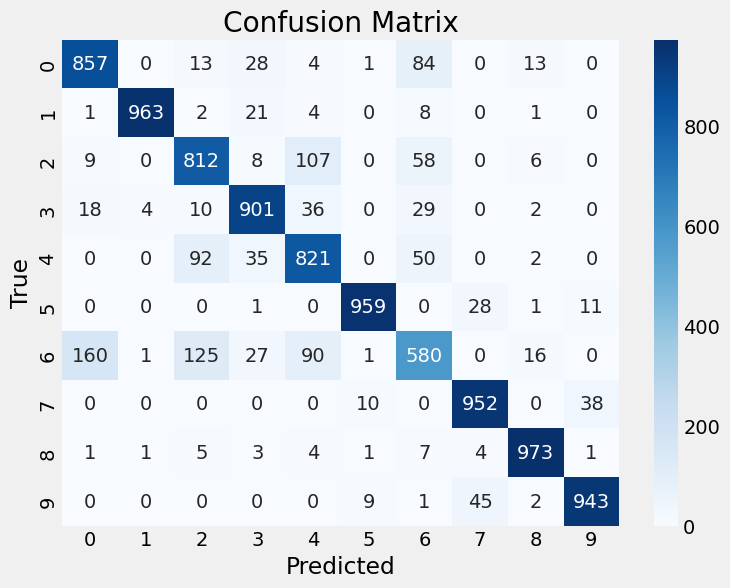

In [26]:
# Evaluate the default random forest
print("Evaluation for Best Random Forest:")

y_test_pred = best_model.predict(X_test_normalized)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\nRandom Forest model with hypertuned parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show();

### 4.1.4 Interpretability of Random Forest Classifier


Feature Importance:
         Feature    Importance
546  feature_546  1.091544e-02
262  feature_262  7.491212e-03
602  feature_602  7.445132e-03
406  feature_406  7.040607e-03
574  feature_574  6.803885e-03
..           ...           ...
26    feature_26  2.462712e-06
55    feature_55  2.370630e-06
27    feature_27  2.072237e-06
1      feature_1  4.387575e-07
0      feature_0  3.610304e-07

[784 rows x 2 columns]


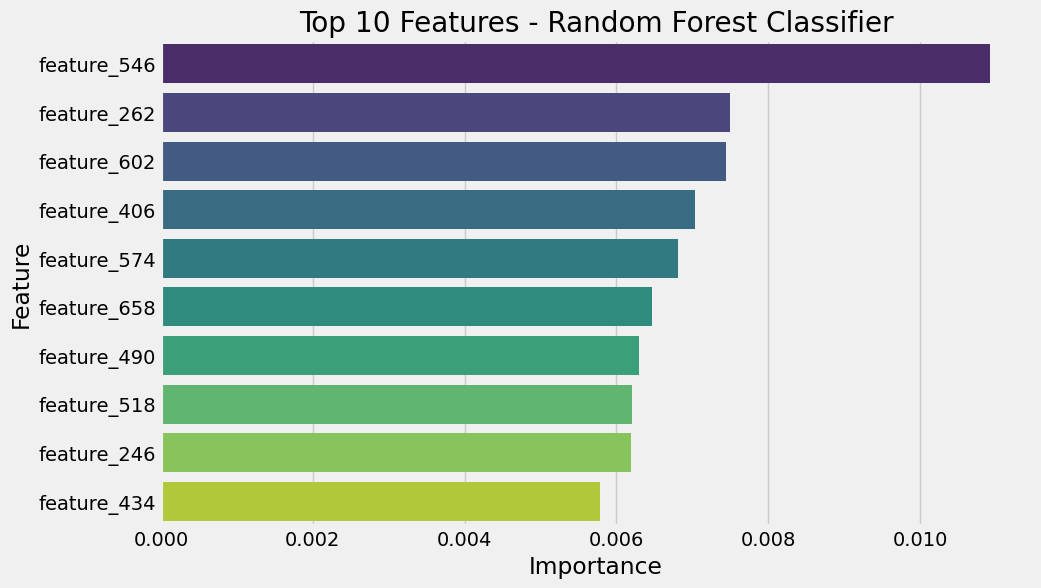

In [27]:
import seaborn as sns

# Get feature importances from the trained model
feature_importances = best_model.feature_importances_

# If X_train is a NumPy array and doesn't have columns, create a list of feature names
feature_names = [f'feature_{i}' for i in range(X_train_normalized.shape[1])]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print("\nFeature Importance:")
print(feature_importance_df)

# Plot the top N important features horizontally using Seaborn
top_n = 10  # Change this value to display a different number of top features
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bar_plot = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Features - Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show();


## 4.2 XGBoost Classifier

### 4.2.1 Default XGBoost Classifier

In [28]:
# Flatten the images and scale pixel values to mean=0.0 and var=1.0
X_train = X_train.reshape(X_train.shape[0], -1)
X_train= (X_train - np.mean(X_train)) / np.std(X_train)

# Flatten the images and scale pixel values to mean=0.0 and var=1.0
X_test = X_test.reshape(X_test.shape[0], -1)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [29]:
# Print the dimensions of the dataset after normalizing
print('Train: X = ', X_train_normalized.shape)
print('Test: X = ', X_test_normalized.shape)

Train: X =  (60000, 784)
Test: X =  (10000, 784)


In [30]:
C = load('/content/drive/Shareddrives/ECEN758 Group Jarvis/Colab Notebooks/xgboost_classifier_default.joblib')

Evaluation for Default XGBoost:


\XGBoost model with default parameters:

Test Accuracy: 89.69%
Precision: 0.8965
Recall: 0.8969
F1-Score: 0.8965


Confusion Matrix:


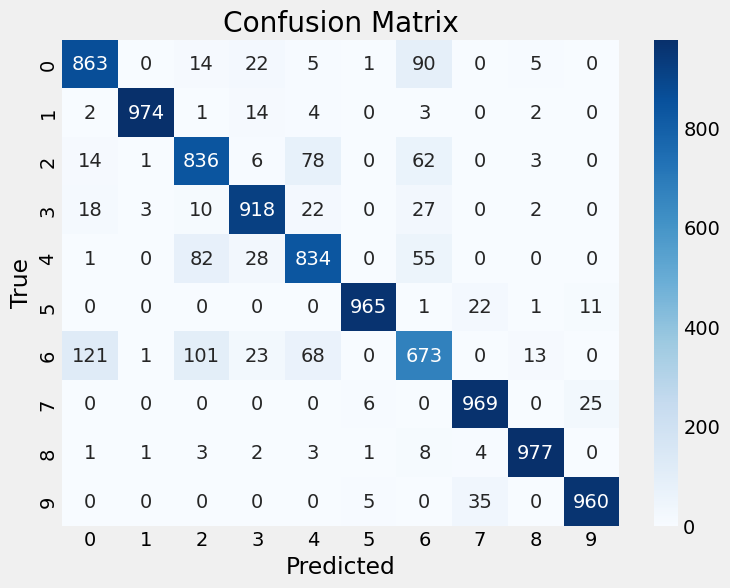

In [31]:
# Evaluate the default random forest
print("Evaluation for Default XGBoost:")

y_test_pred = C.predict(X_test)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\XGBoost model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show();

### 4.2.2 HyperParameter Tuning


```python
# Define the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='multi:softprob', num_class=10, seed=SEED)

# Hyperparameter tuning using Bayesian optimization
param_space = {
    'learning_rate': (0.1, 0.5),
    'max_depth': (8, 12),
    'n_estimators': (70, 130),
    'subsample': (0.5, 1.0),
    'min_child_weight': (0, 4),
}

bayes_opt = BayesSearchCV(
    xgb_classifier,
    param_space,
    n_iter=15,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
    scoring='accuracy', # Accuracy as metric
    verbose=10,  # Adjust verbosity level (0 for no output, higher integers for more details)
)

bayes_opt.fit(X_train, y_train)

# Access the cross-validation results
cv_results = bayes_opt.cv_results_

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Mean Score': cv_results['mean_test_score'],
    'Std Dev Score': cv_results['std_test_score'],
    'Params': cv_results['params']
})

results_df = results_df.sort_values(by='Mean Score', ascending=False)
header = ["Index", "Mean Score", "Std Dev Score", "Params"]
results_df.index.name = "Index"
results_df.reset_index(inplace=True)

# Display the cross-validation results
print(results_df.to_markdown(headers=header, index=False))
print("\n" + "="*40 + "\n")


# Print the best hyperparameters
best_params = bayes_opt.best_params_
print("Best Hyperparameters:", best_params)

# Initialize the XGBoost classifier with best parameters
xgb_best_model = xgb.XGBClassifier(**hyperparameters)
joblib.dump(xgb_best_model, 'xgboost_classifier_hypertuned.joblib')
```

### 4.2.3 Evaluation of Best Model

Evaluation for Hyper-tuned XGBoost:


\XGBoost model with default parameters:

Test Accuracy: 89.80%
Precision: 0.8973
Recall: 0.8980
F1-Score: 0.8973


Confusion Matrix:


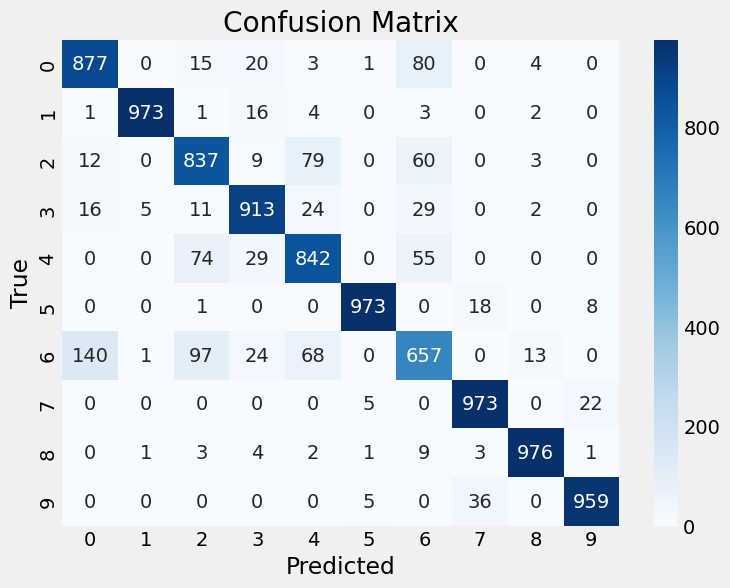

In [32]:
D = load('/content/drive/Shareddrives/ECEN758 Group Jarvis/Colab Notebooks/xgboost_classifier_hypertuned.joblib')
# Evaluate the hyper-tuned random forest
print("Evaluation for Hyper-tuned XGBoost:")

y_test_pred = D.predict(X_test)

# Model evaluation on the test set
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_test_pred)

print("\n" + "="*40 + "\n")
print("\XGBoost model with default parameters:\n")

# Print evaluation metrics for the test set
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\n" + "="*40 + "\n")
print("Confusion Matrix:")

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show();

### 4.2.4 Interpretability of XGBoost Model


Feature Importance:
         Feature  Importance
337  feature_337    0.070449
346  feature_346    0.041199
471  feature_471    0.039846
490  feature_490    0.031988
339  feature_339    0.024943
..           ...         ...
56    feature_56    0.000000
54    feature_54    0.000000
27    feature_27    0.000000
26    feature_26    0.000000
0      feature_0    0.000000

[784 rows x 2 columns]


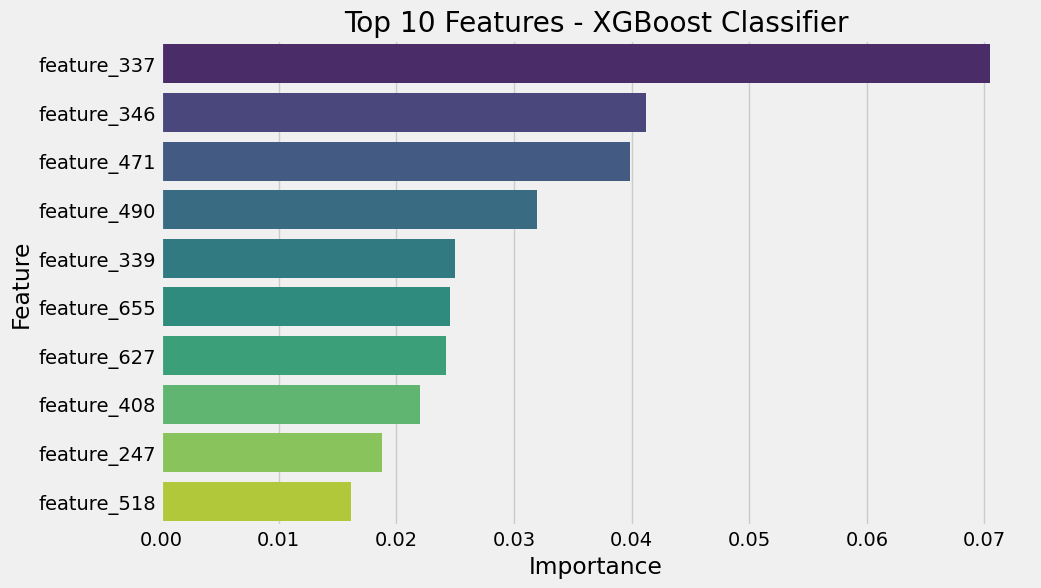

In [33]:
import seaborn as sns

# Get feature importances from the trained model
feature_importances = D.feature_importances_

# If X_train is a NumPy array and doesn't have columns, create a list of feature names
feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importance table
print("\nFeature Importance:")
print(feature_importance_df)

# Plot the top N important features horizontally using Seaborn
top_n = 10  # Change this value to display a different number of top features
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
bar_plot = sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n), palette='viridis')
plt.title(f'Top {top_n} Features - XGBoost Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show();


# 4.3 Deep Learning

## 4.3.1 Setup

In [34]:
# Load the FashionMNIST dataset from PyTorch
train_set = torchvision.datasets.FashionMNIST(root="data", download=True, train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST(root="data", download=True, train=False,
                                             transform=transforms.Compose([transforms.ToTensor()]))

# Print the shape of train/test features/labels
print(train_set.data.shape)
print(train_set.targets.shape)
print(test_set.data.shape)
print(test_set.targets.shape)

100%|██████████| 26421880/26421880 [00:02<00:00, 13040850.69it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 209637.78it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3888686.82it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19974354.29it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

torch.Size([60000, 28, 28])
torch.Size([60000])
torch.Size([10000, 28, 28])
torch.Size([10000])


In [35]:
# Get the name of the labels
labels_map = {v: k for k, v in train_set.class_to_idx.items()}
labels_list = train_set.classes
print(labels_map)  # A dictionary mapping integer labels to readable label names
print(labels_list) # A list of label names with their indices being their corresponding integer labels

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 4.3.2 Dataset & Model & Hyperparameter Definition

In [36]:
# Define PyTorch Dataset to combine X and y
class CombineDataset(Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [37]:
class FashionMLP(nn.Module):

    def __init__(self):
        super(FashionMLP, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=28 * 28, out_features=400),
            nn.Linear(in_features=400, out_features=150),
            nn.Linear(in_features=150, out_features=10)
        )

    def forward(self, x):
        x = x.view(len(x), -1)
        return self.layers(x)

In [38]:
class FashionCNN(nn.Module):

    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(                                                # x is [bs, 1, 28, 28]
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),    # Size([bs, 32, 28, 28])
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),                                                        # Size([bs, 32, 14, 14])
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),              # Size([bs, 64, 12, 12])
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)                                                         # Size([bs, 64, 6, 6])
        )

        self.output_layers = nn.Sequential(
            nn.Linear(in_features=64 * 6 * 6, out_features=600),                    # Size([bs, 600])
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=600, out_features=120),                           # Size([bs, 120])
            nn.Linear(in_features=120, out_features=10),                            # Size([bs, 10])
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.output_layers(out)

        return out

In [39]:
# Hyperparameter definition
Params = namedtuple("Params", ["num_epochs", "learning_rate", "batch_size", "max_early_stop"])

## 4.3.3 Model Training & Cross Validation

### 4.3.3.1 Functions for training & cross validation

In [40]:
def train(model, train_loader, val_loader, hyperparameters, save_path, loss_fn=torch.nn.CrossEntropyLoss(), val=True, show_tqdm=False, verbose=False):

    # Parse out the hyperparameters
    num_epochs = hyperparameters.num_epochs
    learning_rate = hyperparameters.learning_rate
    max_early_stop = hyperparameters.max_early_stop

    # Data to record for all epochs
    train_records = {
        "loss": [],
        "accuracy": [],
        "report": [],
    }

    val_records = {
        "loss": [],
        "accuracy": [],
        "report": [],
    }

    # Model setup
    print(f"device={device}")
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Model training
    early_stop_count = 0
    min_loss = np.inf

    for epoch_i in range(num_epochs):

        # Switch to train mode
        model.train()

        # Records within each training epoch
        train_running_loss = 0
        train_total_correct = 0
        train_y_true = []
        train_y_pred = []

        # Training Epoch
        set_seed()
        train_progress_bar = tqdm(train_loader) if show_tqdm else train_loader
        for batch_i, (train_images, train_labels) in enumerate(train_progress_bar, start=1):

            # Send images and labels to GPU if available
            train_images, train_labels = train_images.to(device), train_labels.to(device)

            # Cast dtype to torch.float (from unsigned char) & Add additional dim for channels
            train_images = train_images.view(train_images.size(0), 1, 28, 28).to(torch.float)

            # Zero the gradients to avoid mixing of gradients among batches
            optimizer.zero_grad()

            # Forward pass
            train_outputs = model(train_images)

            # Compute loss
            loss = loss_fn(train_outputs, train_labels)
            train_running_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Make predictions on training set
            _, train_predicted = torch.max(train_outputs.detach(), 1) # get the index of the class with the highest probability
            train_total_correct += (train_predicted == train_labels).sum().item()

            # Collect predictions and labels
            train_y_true.extend(train_labels.cpu().numpy())
            train_y_pred.extend(train_predicted.cpu().numpy())

        # Calculate metrics
        epoch_loss = train_running_loss / len(train_loader) # loss per batch
        epoch_accuracy = train_total_correct / len(train_loader.dataset) # Overall train accuracy
        epoch_report = classification_report(train_y_true, train_y_pred, output_dict=True, zero_division=0)

        # Record metrics
        train_records["loss"].append(epoch_loss)
        train_records["accuracy"].append(epoch_accuracy)
        train_records["report"].append(epoch_report)

        # =======================================================================

        # Switch to eval mode
        model.eval()

        # Records within each validation epoch
        val_running_loss = 0
        val_total_correct = 0
        val_y_true = []
        val_y_pred = []

        with torch.no_grad():

            # Validation epoch
            set_seed()
            val_progress_bar = tqdm(val_loader) if show_tqdm else val_loader
            for val_images, val_labels in val_progress_bar:

                # Send images and labels to GPU if available
                val_images, val_labels = val_images.to(device), val_labels.to(device)

                # Cast dtype to torch.float (from unsigned char)
                val_images = val_images.view(val_images.size(0), 1, 28, 28).to(torch.float)

                # Make predictions on validation set
                val_outputs = model(val_images)
                _, val_predicted = torch.max(val_outputs.detach(), 1)
                val_total_correct += (val_predicted == val_labels).sum().item()

                # Compute loss
                loss = loss_fn(val_outputs, val_labels)
                val_running_loss += loss.item()

                # Collect predictions and labels
                val_y_true.extend(val_labels.cpu().numpy())
                val_y_pred.extend(val_predicted.cpu().numpy())


        # Calculate metrics
        val_loss = val_running_loss / len(val_loader) # loss per batch
        val_accuracy = val_total_correct / len(val_loader.dataset) # Overall val accuracy
        val_report = classification_report(val_y_true, val_y_pred, output_dict=True, zero_division=0)
        val_f1 = val_report["macro avg"]["f1-score"]

        # Print current model performance
        if verbose:
            print(f"Epoch[{epoch_i+1}/{num_epochs}]: Train Loss: {epoch_loss:.4f} / Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Macro F1-Score: {val_f1:.4f} {'***' if val_loss < min_loss else ''}")

        # Record metrics
        val_records["loss"].append(val_loss)
        val_records["accuracy"].append(val_accuracy)
        val_records["report"].append(val_report)

        # Early Stopping
        if val_loss < min_loss:
            min_loss = val_loss
            # Save current model
            torch.save(model.state_dict(), save_path)
            best_model = model
            early_stop_count = 0
        else:
            early_stop_count += 1

        if early_stop_count >= max_early_stop:
            print(f'\nModel is not improving for {max_early_stop} epochs, halt the training session.')
            break

    print("Training finished.")
    return train_records, val_records

In [41]:
def cross_validation(model, train_set, hyperparameters, fold_num=5, verbose=False):

    # Parse out hyperparameters
    print(hyperparameters)
    num_epochs = hyperparameters.num_epochs
    learning_rate = hyperparameters.learning_rate
    batch_size = hyperparameters.batch_size
    max_early_stop = hyperparameters.max_early_stop

    # Stratified K-fold split
    set_seed()
    stratified_kfold = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=SEED)
    data_splits = stratified_kfold.split(X=train_set.data, y=train_set.targets)

    fold_records = []
    fold_model_save_paths = []
    for fold_i, (train_ids, val_ids) in enumerate(data_splits):
        set_seed()
        if verbose:
            print_colored_text(f"{'= '*35} Fold-{fold_i} {' ='*35}", background_color="MediumSeaGreen", bold=True)

        # Get train/val Dataset for this fold
        X_train = train_set.data[train_ids]
        y_train = train_set.targets[train_ids]
        train_dataset = CombineDataset(X_train, y_train)

        X_val = train_set.data[val_ids]
        y_val = train_set.targets[val_ids]
        val_dataset = CombineDataset(X_val, y_val)

        # Define train/val DataLoaders for this fold
        set_seed()
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Define path to save model
        model_save_path = f"PyTorch_models/{model.__class__.__name__}_fold{fold_i}_lr{learning_rate}_batch{batch_size}_epoch{num_epochs}_earlystop{max_early_stop}"

        # Train the model
        train_records, val_records = train(model, train_loader, val_loader, hyperparameters, model_save_path, verbose=verbose)

        # Save results for this fold
        fold_records.append((train_records, val_records))
        fold_model_save_paths.append(model_save_path)


    del train_loader, val_loader, model, train_records, val_records

    return fold_records, fold_model_save_paths

### 4.3.3.2 FashionMLP (training & cross-validation)

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=3000, learning_rate=0.001, batch_size=100, max_early_stop=100)
# Instantiate model
fashion_mlp = FashionMLP().to(device)
# Print model structures
print(fashion_mlp)
# Cross validation
fashion_mlp_fold_records, fashion_mlp_fold_model_save_paths = cross_validation(fashion_mlp, train_set, hyperparameters, fold_num=5, verbose=True)
# Delete model (to save memory)
del fashion_mlp

with open("PyTorch_model_results/fashion_mlp_fold_records.pkl", "wb") as pkl_file:
  pickle.dump(fashion_mlp_fold_records, pkl_file)

with open("PyTorch_model_results/fashion_mlp_fold_model_save_paths.pkl", "wb") as pkl_file:
  pickle.dump(fashion_mlp_fold_model_save_paths, pkl_file)
```

### 4.3.3.3 FashionCNN (training & cross-validation)

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Print model structures
print(fashion_cnn)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=True)
# Delete model (to save memory)
del fashion_cnn

with open("PyTorch_model_results/fashion_cnn_fold_records.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open("PyTorch_model_results/fashion_cnn_fold_model_save_paths.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

## 4.3.4 Visualize Cross-validation Results

### 4.3.4.1 Functions for visualization

In [42]:
def get_Kfold_report(fold_reports, fold_num=5, keys=None, metrics=None):
    if keys is None:
        keys = list("0123456789") + ["macro avg", "weighted avg"]

    if metrics is None:
        metrics = ["precision", "recall", "f1-score"]

    # Collect metrics from all reports
    all_fold_metrics = []
    for fold_report in fold_reports:
        fold_metrics = []
        for avg, metric in itertools.product(keys, metrics):
            fold_metrics.append(fold_report[avg][metric])
        all_fold_metrics.append(fold_metrics)
    # Create K-fold report
    multiindex_columns = pd.MultiIndex.from_tuples(itertools.product(keys, metrics))
    Kfold_report = pd.DataFrame(all_fold_metrics, columns=multiindex_columns, index=range(1, len(fold_reports)+1))
    Kfold_report.index.name = "fold"
    # Add bottom avg row
    bottem_avg_row = Kfold_report.mean().rename("avg").to_frame().T
    Kfold_report = pd.concat((Kfold_report, bottem_avg_row))

    return Kfold_report

def plot_Kfold_report(Kfold_report, title=""):
    with pd.option_context("display.colheader_justify", "left"):
        print_colored_text(title, background_color="lightblue", font_color="black", bold=True)
        display(Kfold_report)

def get_Kfold_loss_accuracy(fold_best_losses, fold_best_accuracies):
    # Create DataFrame
    multiindex_columns = pd.MultiIndex.from_tuples((("Overall", "loss"), ("Overall", "accuracy")))
    final_Kfold_loss_accuracy = pd.DataFrame(np.array([fold_best_losses, fold_best_accuracies]).T,
                                             columns=multiindex_columns, index=range(1, len(fold_best_losses)+1))
    # Rename the index
    final_Kfold_loss_accuracy.index.name = "fold"
    # Add bottom avg row
    bottem_avg_row = final_Kfold_loss_accuracy.mean().rename("avg").to_frame().T
    final_Kfold_loss_accuracy = pd.concat((final_Kfold_loss_accuracy, bottem_avg_row))

    return final_Kfold_loss_accuracy

def get_final_train_val_Kfold_reports(fold_records, hyperparameters):

    # Parse out hyperparameters
    num_epochs = hyperparameters.num_epochs
    max_early_stop = hyperparameters.max_early_stop

    # Iterate through each fold to get metrics on its best model
    best_train_fold_losses = []
    best_val_fold_losses = []

    best_train_fold_accuracies = []
    best_val_fold_accuracies = []

    best_train_fold_reports = []
    best_val_fold_reports = []

    for train_records, val_records in fold_records:

        # Find the epoch in which we get the best model
        fold_num_epochs_ran = len(train_records["loss"])
        fold_best_report_position = -max_early_stop-1 if fold_num_epochs_ran < num_epochs else -1

        # Get the metrics in that epoch (the best model)
        # 1) Get the epoch's loss
        best_train_fold_losses.append(train_records["loss"][fold_best_report_position])
        best_val_fold_losses.append(val_records["loss"][fold_best_report_position])

        # 2) Get the epoch's accuracy
        best_train_fold_accuracies.append(train_records["accuracy"][fold_best_report_position])
        best_val_fold_accuracies.append(val_records["accuracy"][fold_best_report_position])

        # 3) Get the epoch's report (precision, recall, f1-score)
        best_train_epoch_records = train_records["report"][fold_best_report_position]
        best_val_epoch_records = val_records["report"][fold_best_report_position]

        best_train_fold_reports.append(best_train_epoch_records)
        best_val_fold_reports.append(best_val_epoch_records)


    # Summarize the losses and accuracies for each fold into a dataframes
    final_train_Kfold_loss_accuracy = get_Kfold_loss_accuracy(best_train_fold_losses, best_train_fold_accuracies)
    final_val_Kfold_loss_accuracy = get_Kfold_loss_accuracy(best_val_fold_losses, best_val_fold_accuracies)

    del best_train_fold_losses, best_train_fold_accuracies, best_val_fold_losses, best_val_fold_accuracies

    # Summarize the reports into dataframes
    keys = list("0123456789") + ["macro avg", "weighted avg"]
    final_train_Kfold_report = get_Kfold_report(best_train_fold_reports, keys=keys)
    final_val_Kfold_report = get_Kfold_report(best_val_fold_reports, keys=keys)

    del best_train_fold_reports, best_val_fold_reports

    # Column-wise concat the two summary tables
    final_train_Kfold_report = pd.concat((final_train_Kfold_loss_accuracy, final_train_Kfold_report), axis=1)
    final_val_Kfold_report = pd.concat((final_val_Kfold_loss_accuracy, final_val_Kfold_report), axis=1)

    return final_train_Kfold_report, final_val_Kfold_report

def get_metrics_from_report(records):
    # Set up 3 empty dictionaries
    keys = list("0123456789") + ["macro avg", "weighted avg"]
    precision, recall, f1 = {}, {}, {}
    for key in keys:
        precision[key] = []
        recall[key] = []
        f1[key] = []

    # Add metrics from report to empty dictionaries
    for report in records["report"]:
        # Extract metrics for each class
        for key in keys:
            precision[key].append(report[key]["precision"])
            recall[key].append(report[key]["recall"])
            f1[key].append(report[key]["f1-score"])

    return precision, recall, f1

def plot_results(train_records, val_records, plot_start_index=0, plot_each_class=False):
    num_epochs_ran = len(train_records["loss"])
    x_values = range(plot_start_index, num_epochs_ran)

    train_precision, train_recall, train_f1 = get_metrics_from_report(train_records)
    val_precision, val_recall, val_f1 = get_metrics_from_report(val_records)
    labels = train_precision.keys()

    # Plot Overall Loss & Accuracy
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 3))
    for  ax, metric in zip(axes, ("loss", "accuracy")):
        _ = ax.plot(x_values, train_records[metric][plot_start_index:], label=f"train {metric}")
        _ = ax.plot(x_values, val_records[metric][plot_start_index:], label=f"val {metric}")
        _ = ax.set_title(metric.title())
        _ = ax.legend()

    # Plot metrics (precision, recall, f1-score) for each class
    figsize = (13, 24)
    if not plot_each_class:
        labels = ["macro avg", "weighted avg"]
        figsize = (13, 4)
    fig, axes = plt.subplots(nrows=len(labels), ncols=3, figsize=figsize, sharey=True)
    for i, (axes_row, label) in enumerate(zip(axes, labels)):

        _ = axes_row[0].plot(x_values, train_precision[label][plot_start_index:], label=f"train precision")
        _ = axes_row[0].plot(x_values, val_precision[label][plot_start_index:], label=f"val precision")
        _ = axes_row[0].set_ylabel(label.title())
        _ = axes_row[0].set_title("Precision" if i == 0 else None)

        _ = axes_row[1].plot(x_values, train_recall[label][plot_start_index:], label=f"train recall")
        _ = axes_row[1].plot(x_values, val_recall[label][plot_start_index:], label=f"val recall")
        _ = axes_row[1].set_title("Recall" if i == 0 else None)

        _ = axes_row[2].plot(x_values, train_f1[label][plot_start_index:], label=f"train f1-score")
        _ = axes_row[2].plot(x_values, val_f1[label][plot_start_index:], label=f"val f1-score")
        _ = axes_row[2].set_title("F1-Score" if i == 0 else None)

        for ax in axes_row:
            _ = ax.legend();

    plt.tight_layout()
    plt.show()

In [43]:
@mpl.rc_context({'font.size': 16})
def plot_confusion_matrix(true_values, predictions, labels, figsize=(24, 12)):
    cm = confusion_matrix(true_values, predictions, labels=labels)
    pct_cm = confusion_matrix(true_values, predictions, labels=labels, normalize="true")

    cm_display = ConfusionMatrixDisplay(cm, display_labels=labels)
    pct_cm_display = ConfusionMatrixDisplay(pct_cm, display_labels=labels)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    cm_display.plot(ax=axes[0], cmap=plt.cm.Blues)
    pct_cm_display.plot(ax=axes[1], cmap=plt.cm.Blues, values_format=".2%")

    axes[0].grid(False)
    axes[1].grid(False)

    plt.show()

def get_classification_report_dict(true_values, predictions, show_report=False, show_confusion_matrix=False):

    convert_datatype = lambda array: array if isinstance(array, list) else array.values
    true_values = convert_datatype(true_values)
    predictions = convert_datatype(predictions)

    report_dict = classification_report(true_values, predictions, output_dict=True, zero_division=0.0)

    if show_report:
        print(classification_report(true_values, predictions))

    if show_confusion_matrix:
        plot_confusion_matrix(true_values, predictions, labels_list)

    return report_dict

In [44]:
def visualize_cv_results(fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False):
    final_train_Kfold_report, final_val_Kfold_report = get_final_train_val_Kfold_reports(fold_records, hyperparameters)
    if plot_train_report:
        plot_Kfold_report(final_train_Kfold_report, title="Training (Each fold has different train data):")
    plot_Kfold_report(final_val_Kfold_report, title="Validation (Each fold has different val data):")

    if not add_line_plots: return

    for i, (train_records, val_records) in enumerate(fold_records, start=1):
        print_colored_text(f"{'= '*35} Fold-{i} {' ='*35}", background_color="MediumSeaGreen", bold=True)
        plot_results(train_records, val_records, plot_start_index=0, plot_each_class=plot_each_class)

### Results of FashionMLP (not  fine-tuned)

In [45]:
with open(os.path.join(root_dir, "PyTorch_model_results/fashion_mlp_fold_records.pkl"), "rb") as pkl_file:
    fashion_mlp_fold_records = pickle.load(pkl_file)

In [46]:
hyperparameters = Params(num_epochs=3000, learning_rate=0.001, batch_size=100, max_early_stop=100)
visualize_cv_results(fashion_mlp_fold_records, hyperparameters, plot_train_report=True, add_line_plots=True, plot_each_class=True)

Output hidden; open in https://colab.research.google.com to view.

### Results of FashionCNN (not  fine-tuned)

In [47]:
with open(os.path.join(root_dir, "PyTorch_model_results/fashion_cnn_fold_records.pkl"), "rb") as pkl_file:
    fashion_cnn_fold_records = pickle.load(pkl_file)

In [48]:
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
visualize_cv_results(fashion_cnn_fold_records, hyperparameters, plot_train_report=True, add_line_plots=True, plot_each_class=True)

Output hidden; open in https://colab.research.google.com to view.

As we can see, FashionCNN performs better than FashionMLP.

## 4.3.5 HyperParameter Tuning

### 4.3.5.1 Hyperparameter tuning - Result Summary
| Experiments | num_epochs | learning_rate | batch_size | max_early_stop | CV Accuracy | CV Precision | CV Recall | CV F1-score |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | 500 | 0.001 | 100 | 50 | 0.887783 | 0.888317 | 0.887783 | 0.886969 |
| 2 | 500 | 0.0005 | 100 | 50 | 0.948383 | 0.948526 | 0.948383 | 0.948221 |
| 3 | 500 | 0.00001 | 100 | 50 | 0.958900 | 0.958848 | 0.958900 | 0.958788 |
| 4 | 500 | 0.001 | 150 | 50 | 0.901717 | 0.902467 | 0.901717 | 0.901210 |
| 5 | 500 | 0.0005 | 150 | 50 | 0.962467 | 0.962599 | 0.962467 | 0.962405 |
| 6 | 500 | 0.00001 | 150 | 50 | 0.960750 | 0.960808 | 0.960750 | 0.960729 |
| 7 | 500 | 0.001 | 200 | 50 | 0.913417 | 0.913948 | 0.913417 | 0.912967 |
| 8 | 500 | 0.0005 | 200 | 50 | **0.966467** | **0.966629** | **0.966467** | **0.966483** |
| 9 | 500 | 0.00001 | 200 | 50 | 0.959300 | 0.959284 | 0.959300 | 0.959222 |

As we can see above, setting the `learning_rate` to 0.0005 and `batch_size` to 200 gives the best result.<br>
Below are the code for these 9 experiments.

### Experiment 1: learning_rate = 0.001, batch_size = 100

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=100, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [49]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=100, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.573333  0.887417  0.817610  0.866667  0.841424  0.987245  0.967500   
2    1.567925  0.893167  0.778343  0.892500  0.831522  0.987310  0.972500   
3    1.574391  0.886750  0.792237  0.867500  0.828162  0.993238  0.979167   
4    1.575321  0.885833  0.827221  0.845833  0.836424  0.996572  0.969167   
5    1.575400  0.885750  0.734707  0.920833  0.817308  0.998256  0.954167   
avg  1.573274  0.887783  0.790024  0.878667  0.830968  0.992524  0.968500   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.977273  0.836664  0.802500  0.819226  0.841629  0.930000  0.883610   
2    0.979849  0.865158  0.796667  0.829501  0.890057  0.917500  0.903570   
3    0.986152  0.864986  0.800833  0.831675  0.896377  0.886667  0.891496   
4    0.982678  0.808144  0.860000  0.833266  0.863816  0.909167  0.885911   
5    0.975714  0.823151  0.853333  0.837971  0.910488  0.839167  0.873374   
avg  0.980333  0.839621  0.822667  0.830328  0.880474  0.896500  0.887592   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.807660  0.790833  0.799158  0.939054  0.975833  0.957090  0.753259   
2    0.784358  0.860833  0.820818  0.976471  0.968333  0.972385  0.756269   
3    0.796431  0.818333  0.807234  0.987080  0.955000  0.970775  0.706957   
4    0.817324  0.794167  0.805579  0.944623  0.980833  0.962388  0.741627   
5    0.814483  0.834167  0.824207  0.976923  0.952500  0.964557  0.745158   
avg  0.804051  0.819667  0.811399  0.964830  0.966500  0.965439  0.740654   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.674167  0.711522  0.939620  0.946667  0.943130  0.965975  0.970000   
2    0.628333  0.686391  0.943548  0.975000  0.959016  0.987147  0.960000   
3    0.677500  0.691915  0.893455  0.978333  0.933970  0.967954  0.981667   
4    0.645833  0.690423  0.920800  0.959167  0.939592  0.946774  0.978333   
5    0.609167  0.670335  0.933657  0.961667  0.947455  0.987147  0.960000   
avg  0.647000  0.690117  0.926216  0.964167  0.944633  0.970999  0.970000   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.967983  0.978541  0.950000  0.964059  0.886726  0.887417  0.886448   
2    0.973384  0.968881  0.960000  0.964420  0.893754  0.893167  0.892086   
3    0.974762  0.979646  0.922500  0.950215  0.887836  0.886750  0.886635   
4    0.962295  0.982127  0.915833  0.947822  0.884903  0.885833  0.884638   
5    0.973384  0.959704  0.972500  0.966060  0.888367  0.885750  0.885036   
avg  0.970362  0.973780  0.944167  0.958515  0.888317  0.887783  0.886969   

    weighted avg                      
    precision    recall    f1-score   
1    0.886726     0.887417  0.886448  
2    0.893754     0.893167  0.892086  
3    0.887836     0.886750  0.886635  
4    0.884903     0.885833  0.884638  
5    0.888367     0.885750  0.885036  
avg  0.888317     0.887783  0.886969

### Experiment 2: learning_rate = 0.0005, batch_size = 100

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=100, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [50]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=100, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.541515  0.919583  0.828593  0.898333  0.862055  0.985714  0.977500   
2    1.505999  0.955083  0.915132  0.952500  0.933442  0.997481  0.990000   
3    1.506695  0.954333  0.933278  0.932500  0.932889  0.991701  0.995833   
4    1.505623  0.955583  0.940120  0.915833  0.927818  0.997485  0.991667   
5    1.503808  0.957333  0.925566  0.953333  0.939245  0.992512  0.994167   
avg  1.512728  0.948383  0.908538  0.930500  0.919090  0.992979  0.989833   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.981590  0.886729  0.874167  0.880403  0.920136  0.902500  0.911233   
2    0.993726  0.911789  0.921667  0.916701  0.949264  0.966667  0.957886   
3    0.993763  0.882806  0.954167  0.917101  0.954470  0.960833  0.957641   
4    0.994567  0.888626  0.937500  0.912409  0.959098  0.957500  0.958299   
5    0.993339  0.923583  0.936667  0.930079  0.957781  0.964167  0.960963   
avg  0.991397  0.898706  0.924833  0.911338  0.948150  0.950333  0.949204   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.870627  0.891667  0.881021  0.982485  0.981667  0.982076  0.823741   
2    0.923461  0.925000  0.924230  0.996616  0.981667  0.989085  0.907801   
3    0.920596  0.927500  0.924035  0.997481  0.990000  0.993726  0.914736   
4    0.933898  0.918333  0.926050  0.992519  0.995000  0.993758  0.887490   
5    0.921521  0.949167  0.935140  0.989992  0.989167  0.989579  0.921196   
avg  0.914020  0.922333  0.918095  0.991819  0.987500  0.989645  0.890993   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.763333  0.792388  0.952730  0.974167  0.963329  0.970223  0.977500   
2    0.853333  0.879725  0.975166  0.981667  0.978405  0.995809  0.990000   
3    0.822500  0.866169  0.979132  0.977500  0.978315  0.990879  0.995833   
4    0.880833  0.884149  0.978477  0.985000  0.981728  0.995012  0.997500   
5    0.847500  0.882812  0.981229  0.958333  0.969646  0.999162  0.993333   
avg  0.833500  0.861049  0.973347  0.975333  0.974285  0.990217  0.990833   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.973848  0.976982  0.955000  0.965866  0.919796  0.919583  0.919381   
2    0.992896  0.978548  0.988333  0.983416  0.955107  0.955083  0.954951   
3    0.993350  0.980132  0.986667  0.983389  0.954521  0.954333  0.954038   
4    0.996255  0.985702  0.976667  0.981164  0.955843  0.955583  0.955620   
5    0.996239  0.961071  0.987500  0.974106  0.957361  0.957333  0.957115   
avg  0.990518  0.976487  0.978833  0.977588  0.948526  0.948383  0.948221   

    weighted avg                      
    precision    recall    f1-score   
1    0.919796     0.919583  0.919381  
2    0.955107     0.955083  0.954951  
3    0.954521     0.954333  0.954038  
4    0.955843     0.955583  0.955620  
5    0.957361     0.957333  0.957115  
avg  0.948526     0.948383  0.948221

### Experiment 3: learning_rate = 0.00001, batch_size = 100

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=100, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [51]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=100, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.548653  0.911750  0.860541  0.874167  0.867301  0.983108  0.970000   
2    1.501104  0.961167  0.939292  0.928333  0.933780  0.995802  0.988333   
3    1.493102  0.968667  0.956303  0.948333  0.952301  0.993339  0.994167   
4    1.487770  0.974083  0.952185  0.962500  0.957315  0.995826  0.994167   
5    1.483241  0.978833  0.958128  0.972500  0.965261  0.994996  0.994167   
avg  1.502774  0.958900  0.933290  0.937167  0.935191  0.992614  0.988167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.976510  0.865178  0.871667  0.868410  0.883387  0.921667  0.902121   
2    0.992054  0.937291  0.934167  0.935726  0.939054  0.975833  0.957090   
3    0.993753  0.955907  0.957500  0.956703  0.955029  0.973333  0.964094   
4    0.994996  0.960604  0.955000  0.957794  0.958333  0.977500  0.967822   
5    0.994581  0.971524  0.966667  0.969089  0.966585  0.988333  0.977338   
avg  0.990379  0.938101  0.937000  0.937544  0.940477  0.967333  0.953693   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.856440  0.870000  0.863167  0.977292  0.968333  0.972792  0.800000   
2    0.939318  0.941667  0.940491  0.994108  0.984167  0.989112  0.914821   
3    0.931672  0.965833  0.948445  0.996656  0.993333  0.994992  0.947926   
4    0.957025  0.965000  0.960996  0.998331  0.996667  0.997498  0.949094   
5    0.970906  0.973333  0.972118  0.996661  0.995000  0.995830  0.962003   
avg  0.931072  0.943167  0.937043  0.992609  0.987500  0.990045  0.914769   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.746667  0.772414  0.948445  0.965833  0.957060  0.974916  0.971667   
2    0.895000  0.904802  0.978530  0.987500  0.982995  0.988353  0.990000   
3    0.895000  0.920703  0.982471  0.980833  0.981651  0.981893  0.994167   
4    0.916667  0.932599  0.986678  0.987500  0.987089  0.994181  0.996667   
5    0.928333  0.944869  0.988314  0.986667  0.987490  0.994162  0.993333   
avg  0.876333  0.895077  0.976888  0.981667  0.979257  0.986701  0.989167   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.973289  0.965546  0.957500  0.961506  0.911485  0.911750  0.911457   
2    0.989176  0.985025  0.986667  0.985845  0.961159  0.961167  0.961107   
3    0.987992  0.985810  0.984167  0.984987  0.968700  0.968667  0.968562   
4    0.995422  0.988343  0.989167  0.988755  0.974060  0.974083  0.974028   
5    0.993747  0.985075  0.990000  0.987531  0.978835  0.978833  0.978785   
avg  0.987925  0.981960  0.981500  0.981725  0.958848  0.958900  0.958788   

    weighted avg                      
    precision    recall    f1-score   
1    0.911485     0.911750  0.911457  
2    0.961159     0.961167  0.961107  
3    0.968700     0.968667  0.968562  
4    0.974060     0.974083  0.974028  
5    0.978835     0.978833  0.978785  
avg  0.958848     0.958900  0.958788

### Experiment 4: learning_rate = 0.001, batch_size = 150

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [52]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=150, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.563512  0.897583  0.871979  0.811667  0.840742  0.991468  0.968333   
2    1.553295  0.907750  0.847267  0.878333  0.862520  0.988255  0.981667   
3    1.559315  0.901833  0.822853  0.894167  0.857029  0.994113  0.985000   
4    1.559919  0.901167  0.841473  0.875833  0.858310  0.991575  0.980833   
5    1.560901  0.900250  0.872617  0.839167  0.855565  0.990749  0.981667   
avg  1.559388  0.901717  0.851238  0.859833  0.854833  0.991232  0.979500   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.979764  0.863559  0.849167  0.856303  0.854103  0.936667  0.893482   
2    0.984950  0.874669  0.825833  0.849550  0.923664  0.907500  0.915511   
3    0.989535  0.842585  0.847500  0.845035  0.912134  0.908333  0.910230   
4    0.986175  0.883549  0.796667  0.837862  0.815583  0.950833  0.878030   
5    0.986187  0.894884  0.801667  0.845714  0.904485  0.907500  0.905990   
avg  0.985322  0.871849  0.824167  0.846893  0.881994  0.922167  0.900648   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.805469  0.859167  0.831452  0.969799  0.963333  0.966555  0.738528   
2    0.833065  0.860833  0.846721  0.989655  0.956667  0.972881  0.742812   
3    0.787234  0.863333  0.823529  0.968852  0.985000  0.976860  0.793750   
4    0.810853  0.871667  0.840161  0.995648  0.953333  0.974032  0.803213   
5    0.794603  0.883333  0.836622  0.977406  0.973333  0.975365  0.729753   
avg  0.806245  0.867667  0.835697  0.980272  0.966333  0.973139  0.761611   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.710833  0.724416  0.933547  0.971667  0.952225  0.975589  0.965833   
2    0.775000  0.758564  0.926101  0.981667  0.953074  0.990460  0.951667   
3    0.635000  0.705556  0.946341  0.970000  0.958025  0.964841  0.983333   
4    0.666667  0.728597  0.934713  0.978333  0.956026  0.986577  0.980000   
5    0.713333  0.721450  0.932054  0.971667  0.951448  0.935331  0.988333   
avg  0.700167  0.727717  0.934551  0.974667  0.954160  0.970560  0.973833   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.970687  0.979149  0.939167  0.958741  0.898319  0.897583  0.897437   
2    0.970676  0.978723  0.958333  0.968421  0.909467  0.907750  0.908287   
3    0.973999  0.982699  0.946667  0.964346  0.901540  0.901833  0.900414   
4    0.983278  0.957500  0.957500  0.957500  0.902068  0.901167  0.899997   
5    0.961102  0.977528  0.942500  0.959695  0.900941  0.900250  0.899914   
avg  0.971948  0.975120  0.948833  0.961741  0.902467  0.901717  0.901210   

    weighted avg                      
    precision    recall    f1-score   
1    0.898319     0.897583  0.897437  
2    0.909467     0.907750  0.908287  
3    0.901540     0.901833  0.900414  
4    0.902068     0.901167  0.899997  
5    0.900941     0.900250  0.899914  
avg  0.902467     0.901717  0.901210

### Experiment 5: learning_rate = 0.0005, batch_size = 150

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [53]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=150, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.537843  0.923083  0.872161  0.864167  0.868146  0.988964  0.970833   
2    1.494826  0.966333  0.952381  0.933333  0.942761  0.995833  0.995833   
3    1.489512  0.971667  0.948403  0.965000  0.956629  0.999158  0.989167   
4    1.486922  0.974167  0.943411  0.972500  0.957735  0.996667  0.996667   
5    1.483973  0.977083  0.958949  0.973333  0.966088  0.998328  0.995000   
avg  1.498615  0.962467  0.935061  0.941667  0.938272  0.995790  0.989500   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.979815  0.889718  0.894167  0.891937  0.885246  0.945000  0.914148   
2    0.995833  0.939799  0.936667  0.938230  0.970711  0.966667  0.968685   
3    0.994137  0.952145  0.961667  0.956882  0.953958  0.984167  0.968827   
4    0.996667  0.956811  0.960000  0.958403  0.972085  0.986667  0.979322   
5    0.996661  0.970187  0.949167  0.959562  0.965210  0.994167  0.979475   
avg  0.992623  0.941732  0.940333  0.941003  0.949442  0.975333  0.962091   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.892464  0.878333  0.885342  0.984100  0.980000  0.982046  0.801352   
2    0.939444  0.956667  0.947977  0.999150  0.979167  0.989057  0.914050   
3    0.955833  0.955833  0.955833  0.990871  0.995000  0.992931  0.952423   
4    0.946645  0.975833  0.961018  0.995819  0.992500  0.994157  0.970082   
5    0.946860  0.980000  0.963145  0.996667  0.996667  0.996667  0.969109   
avg  0.936249  0.949333  0.942663  0.993322  0.988667  0.990972  0.921403   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.790000  0.795636  0.958780  0.969167  0.963945  0.991511  0.973333   
2    0.921667  0.917842  0.975309  0.987500  0.981366  0.995830  0.995000   
3    0.900833  0.925910  0.985762  0.980833  0.983292  0.992543  0.998333   
4    0.891667  0.929223  0.983333  0.983333  0.983333  0.998332  0.997500   
5    0.915000  0.941277  0.982616  0.989167  0.985880  0.994176  0.995833   
avg  0.883833  0.901978  0.977160  0.982000  0.979563  0.994479  0.992000   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.982338  0.969064  0.965833  0.967446  0.923336  0.923083  0.923080   
2    0.995415  0.981833  0.990833  0.986313  0.966434  0.966333  0.966348   
3    0.995430  0.985833  0.985833  0.985833  0.971693  0.971667  0.971571   
4    0.997916  0.980100  0.985000  0.982544  0.974329  0.974167  0.974032   
5    0.995004  0.989924  0.982500  0.986198  0.977203  0.977083  0.976996   
avg  0.993221  0.981351  0.982000  0.981667  0.962599  0.962467  0.962405   

    weighted avg                      
    precision    recall    f1-score   
1    0.923336     0.923083  0.923080  
2    0.966434     0.966333  0.966348  
3    0.971693     0.971667  0.971571  
4    0.974329     0.974167  0.974032  
5    0.977203     0.977083  0.976996  
avg  0.962599     0.962467  0.962405

### Experiment 6: learning_rate = 0.00001, batch_size = 150

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=150, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [54]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=150, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.547150  0.913083  0.863447  0.864167  0.863807  0.988136  0.971667   
2    1.497721  0.964500  0.951137  0.940833  0.945957  0.995802  0.988333   
3    1.491570  0.970000  0.951424  0.946667  0.949039  0.994172  0.995000   
4    1.485414  0.976500  0.959268  0.961667  0.960466  0.995823  0.993333   
5    1.482118  0.979667  0.965375  0.975833  0.970576  0.993333  0.993333   
avg  1.500794  0.960750  0.938130  0.937833  0.937969  0.993453  0.988333   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.979832  0.866995  0.880000  0.873449  0.897478  0.919167  0.908193   
2    0.992054  0.957576  0.921667  0.939278  0.954807  0.968333  0.961523   
3    0.994586  0.957711  0.962500  0.960100  0.956735  0.976667  0.966598   
4    0.994577  0.959370  0.964167  0.961762  0.959283  0.981667  0.970346   
5    0.993333  0.974811  0.967500  0.971142  0.965012  0.988333  0.976534   
avg  0.990876  0.943293  0.939167  0.941146  0.946663  0.966833  0.956639   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.873844  0.865833  0.869820  0.976549  0.971667  0.974102  0.767617   
2    0.927361  0.957500  0.942189  0.988362  0.990833  0.989596  0.911716   
3    0.957746  0.963333  0.960532  0.991674  0.992500  0.992087  0.931271   
4    0.961189  0.970000  0.965574  0.996667  0.996667  0.996667  0.959272   
5    0.970978  0.975833  0.973400  0.995826  0.994167  0.994996  0.962134   
avg  0.938224  0.946500  0.942303  0.989816  0.989167  0.989489  0.906402   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.762500  0.765050  0.957025  0.965000  0.960996  0.979713  0.965833   
2    0.920833  0.916252  0.977833  0.992500  0.985112  0.989983  0.988333   
3    0.903333  0.917090  0.979270  0.984167  0.981712  0.990864  0.994167   
4    0.922500  0.940527  0.989176  0.990000  0.989588  0.994181  0.996667   
5    0.931667  0.946655  0.986711  0.990000  0.988353  0.995816  0.991667   
avg  0.888167  0.897115  0.978003  0.984333  0.981152  0.990111  0.987333   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.972723  0.961794  0.965000  0.963394  0.913260  0.913083  0.913137   
2    0.989158  0.992373  0.975833  0.984034  0.964695  0.964500  0.964515   
3    0.992512  0.988255  0.981667  0.984950  0.969912  0.970000  0.969921   
4    0.995422  0.990810  0.988333  0.989570  0.976504  0.976500  0.976450   
5    0.993737  0.986689  0.988333  0.987510  0.979669  0.979667  0.979624   
avg  0.988711  0.983984  0.979833  0.981892  0.960808  0.960750  0.960729   

    weighted avg                      
    precision    recall    f1-score   
1    0.913260     0.913083  0.913137  
2    0.964695     0.964500  0.964515  
3    0.969912     0.970000  0.969921  
4    0.976504     0.976500  0.976450  
5    0.979669     0.979667  0.979624  
avg  0.960808     0.960750  0.960729

### Experiment 7: learning_rate = 0.001, batch_size = 200

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=200, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [55]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.001, batch_size=200, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.555512  0.905417  0.836262  0.872500  0.853997  0.989805  0.970833   
2    1.543314  0.917667  0.869779  0.885000  0.877323  0.987542  0.990833   
3    1.546419  0.914750  0.870550  0.896667  0.883415  0.997468  0.985000   
4    1.543027  0.918167  0.883347  0.870833  0.877046  0.973835  0.992500   
5    1.550069  0.911083  0.895013  0.852500  0.873239  0.969845  0.991667   
avg  1.547668  0.913417  0.870990  0.875500  0.873004  0.983699  0.986167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.980227  0.841054  0.877500  0.858891  0.876494  0.916667  0.896130   
2    0.989185  0.833856  0.886667  0.859451  0.896032  0.940833  0.917886   
3    0.991195  0.880137  0.856667  0.868243  0.901613  0.931667  0.916393   
4    0.983079  0.873836  0.860000  0.866863  0.889512  0.925833  0.907309   
5    0.980635  0.924198  0.792500  0.853297  0.949909  0.869167  0.907746   
avg  0.984864  0.870616  0.854667  0.861349  0.902712  0.916833  0.909093   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.863167  0.835833  0.849280  0.982128  0.961667  0.971789  0.779292   
2    0.838504  0.878333  0.857957  0.972016  0.984167  0.978054  0.854508   
3    0.850796  0.845833  0.848308  0.994048  0.974167  0.984007  0.801954   
4    0.827217  0.901667  0.862839  0.982601  0.988333  0.985459  0.828244   
5    0.800434  0.922500  0.857143  0.976802  0.982500  0.979643  0.722517   
avg  0.836024  0.876833  0.855105  0.981519  0.978167  0.979790  0.797303   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.715000  0.745763  0.937299  0.971667  0.954173  0.979849  0.972500   
2    0.695000  0.766544  0.957342  0.972500  0.964862  0.984127  0.981667   
3    0.752500  0.776440  0.963979  0.936667  0.950127  0.939322  0.993333   
4    0.723333  0.772242  0.967282  0.960833  0.964047  0.983402  0.987500   
5    0.794167  0.756649  0.967687  0.948333  0.957912  0.980865  0.982500   
avg  0.736000  0.763528  0.958718  0.958000  0.958224  0.973513  0.983500   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.976161  0.967254  0.960000  0.963614  0.905260  0.905417  0.905003   
2    0.982895  0.982128  0.961667  0.971789  0.917583  0.917667  0.916595   
3    0.965573  0.942788  0.975000  0.958624  0.914266  0.914750  0.914233   
4    0.985447  0.967608  0.970833  0.969218  0.917688  0.918167  0.917355   
5    0.981682  0.962171  0.975000  0.968543  0.914944  0.911083  0.911649   
avg  0.978352  0.964390  0.968500  0.966358  0.913948  0.913417  0.912967   

    weighted avg                      
    precision    recall    f1-score   
1    0.905260     0.905417  0.905003  
2    0.917583     0.917667  0.916595  
3    0.914266     0.914750  0.914233  
4    0.917688     0.918167  0.917355  
5    0.914944     0.911083  0.911649  
avg  0.913948     0.913417  0.912967

### Experiment 8: learning_rate = 0.0005, batch_size = 200

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [56]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.537443  0.923250  0.877295  0.875833  0.876564  0.988992  0.973333   
2    1.491985  0.969250  0.935405  0.953333  0.944284  0.993350  0.995833   
3    1.485017  0.976167  0.958541  0.963333  0.960931  0.997498  0.996667   
4    1.480467  0.980750  0.961285  0.972500  0.966860  0.997502  0.998333   
5    1.478066  0.982917  0.960033  0.980833  0.970322  0.996667  0.996667   
avg  1.494596  0.966467  0.938512  0.949167  0.943792  0.994802  0.992167   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.981100  0.898660  0.894167  0.896408  0.929991  0.896667  0.913025   
2    0.994590  0.956706  0.939167  0.947855  0.975651  0.968333  0.971978   
3    0.997082  0.961253  0.971667  0.966432  0.964082  0.984167  0.974021   
4    0.997918  0.976109  0.953333  0.964587  0.982456  0.980000  0.981227   
5    0.996667  0.967742  0.975000  0.971357  0.981039  0.991667  0.986324   
avg  0.993471  0.952094  0.946667  0.949328  0.966644  0.964167  0.965315   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.869144  0.896667  0.882691  0.987310  0.972500  0.979849  0.790244   
2    0.942950  0.964167  0.953440  0.997479  0.989167  0.993305  0.930567   
3    0.960931  0.963333  0.962131  0.999162  0.993333  0.996239  0.952298   
4    0.950965  0.985833  0.968085  0.995847  0.999167  0.997504  0.961506   
5    0.971026  0.977500  0.974252  0.999165  0.996667  0.997914  0.975503   
avg  0.939003  0.957500  0.948120  0.995792  0.990167  0.992962  0.922024   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.810000  0.800000  0.954061  0.969167  0.961554  0.976686  0.977500   
2    0.915833  0.923142  0.973813  0.991667  0.982659  0.996656  0.993333   
3    0.915000  0.933277  0.983430  0.989167  0.986290  0.994186  0.997500   
4    0.936667  0.948924  0.994132  0.988333  0.991224  0.996675  0.999167   
5    0.929167  0.951771  0.987583  0.994167  0.990864  0.997500  0.997500   
avg  0.901333  0.911423  0.978604  0.986500  0.982518  0.992341  0.993000   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.977093  0.966667  0.966667  0.966667  0.923905  0.923250  0.923495   
2    0.994992  0.990749  0.981667  0.986187  0.969333  0.969250  0.969243   
3    0.995840  0.989975  0.987500  0.988736  0.976136  0.976167  0.976098   
4    0.997919  0.991687  0.994167  0.992926  0.980816  0.980750  0.980717   
5    0.997500  0.993311  0.990000  0.991653  0.982957  0.982917  0.982862   
avg  0.992669  0.986478  0.984000  0.985234  0.966629  0.966467  0.966483   

    weighted avg                      
    precision    recall    f1-score   
1    0.923905     0.923250  0.923495  
2    0.969333     0.969250  0.969243  
3    0.976136     0.976167  0.976098  
4    0.980816     0.980750  0.980717  
5    0.982957     0.982917  0.982862  
avg  0.966629     0.966467  0.966483

### Experiment 9: learning_rate = 0.00001, batch_size = 200

```python
%%time
# Hyperparameter Set-up
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=200, max_early_stop=50)
# Instantiate model
fashion_cnn = FashionCNN().to(device)
# Cross validation
fashion_cnn_fold_records, fashion_cnn_fold_model_save_paths = cross_validation(fashion_cnn, train_set, hyperparameters, fold_num=5, verbose=False)
# Delete model (to save memory)
del fashion_cnn

# Save model fold records & fold model paths
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

with open(f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_records, pkl_file)

with open(f"PyTorch_model_results/fashion_cnn_new_fold_model_save_paths_{model_name}.pkl", "wb") as pkl_file:
    pickle.dump(fashion_cnn_fold_model_save_paths, pkl_file)
```

In [57]:
# Define the model_name to retrieve data from
hyperparameters = Params(num_epochs=500, learning_rate=0.00001, batch_size=200, max_early_stop=50)
model_name = f"lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"

# Load the fold records
with open(os.path.join(root_dir, f"PyTorch_model_results/fashion_cnn_new_fold_records_{model_name}.pkl"), "rb") as pkl_file:
    fashion_cnn_new_fold_records = pickle.load(pkl_file)

# Visualize the results
visualize_cv_results(fashion_cnn_new_fold_records, hyperparameters, plot_train_report=False, add_line_plots=False, plot_each_class=False)

Overall             0                             1                    \
    loss      accuracy  precision recall    f1-score  precision recall      
1    1.548721  0.912083  0.862923  0.870833  0.866860  0.986452  0.970833   
2    1.500896  0.961667  0.929694  0.936667  0.933167  0.997477  0.988333   
3    1.492926  0.969583  0.946370  0.955833  0.951078  0.995816  0.991667   
4    1.487236  0.974750  0.952263  0.964167  0.958178  0.995826  0.994167   
5    1.483427  0.978417  0.954807  0.968333  0.961523  0.994992  0.993333   
avg  1.502641  0.959300  0.929211  0.939167  0.934161  0.994113  0.987667   

              2                             3                              \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.978580  0.870569  0.880000  0.875259  0.890145  0.918333  0.904020   
2    0.992884  0.948173  0.930000  0.938999  0.950163  0.969167  0.959571   
3    0.993737  0.943089  0.966667  0.954733  0.952922  0.978333  0.965461   
4    0.994996  0.956918  0.962500  0.959701  0.961285  0.972500  0.966860   
5    0.994162  0.966116  0.974167  0.970124  0.964869  0.984167  0.974422   
avg  0.990872  0.936973  0.942667  0.939763  0.943877  0.964500  0.954067   

    4                             5                             6          \
    precision recall    f1-score  precision recall    f1-score  precision   
1    0.860099  0.865833  0.862957  0.976628  0.975000  0.975813  0.778068   
2    0.940784  0.940000  0.940392  0.994958  0.986667  0.990795  0.894343   
3    0.956053  0.960833  0.958437  0.993328  0.992500  0.992914  0.950980   
4    0.959370  0.964167  0.961762  0.998329  0.995833  0.997080  0.951931   
5    0.968465  0.972500  0.970478  0.994176  0.995833  0.995004  0.969325   
avg  0.936954  0.940667  0.938805  0.991484  0.989167  0.990321  0.908930   

                        7                             8                    \
    recall    f1-score  precision recall    f1-score  precision recall      
1    0.745000  0.761175  0.954620  0.964167  0.959370  0.974832  0.968333   
2    0.895833  0.895087  0.978671  0.994167  0.986358  0.990826  0.990000   
3    0.889167  0.919035  0.982515  0.983333  0.982924  0.990849  0.992500   
4    0.924167  0.937844  0.987510  0.988333  0.987922  0.996656  0.993333   
5    0.921667  0.944895  0.985939  0.993333  0.989622  0.990856  0.993333   
avg  0.875167  0.891607  0.977851  0.984667  0.981239  0.988804  0.987500   

              9                             macro avg                      \
    f1-score  precision recall    f1-score  precision recall    f1-score    
1    0.971572  0.964107  0.962500  0.963303  0.911844  0.912083  0.911891   
2    0.990413  0.992450  0.985833  0.989130  0.961754  0.961667  0.961680   
3    0.991674  0.984180  0.985000  0.984590  0.969610  0.969583  0.969458   
4    0.994992  0.987510  0.988333  0.987922  0.974760  0.974750  0.974726   
5    0.992093  0.994962  0.987500  0.991217  0.978451  0.978417  0.978354   
avg  0.988149  0.984642  0.981833  0.983232  0.959284  0.959300  0.959222   

    weighted avg                      
    precision    recall    f1-score   
1    0.911844     0.912083  0.911891  
2    0.961754     0.961667  0.961680  
3    0.969610     0.969583  0.969458  
4    0.974760     0.974750  0.974726  
5    0.978451     0.978417  0.978354  
avg  0.959284     0.959300  0.959222

## 4.3.6 Evaluation of Best Model

In [58]:
# Create train Dataset & DataLoader (w/ full data)
train_dataset = CombineDataset(train_set.data, train_set.targets)
train_loader = DataLoader(train_dataset, batch_size=hyperparameters.batch_size, shuffle=True)

# Create test Dataset & DataLoader
test_dataset = CombineDataset(test_set.data, test_set.targets)
test_loader = DataLoader(test_dataset, batch_size=hyperparameters.batch_size, shuffle=False)

In [59]:
def visualize_test_results(train_records, test_records, hyperparameters, visualize_train=False):

    # Find the epoch in which we get the best model
    num_epochs_ran = len(train_records["loss"])
    position = -hyperparameters.max_early_stop-1 if num_epochs_ran < hyperparameters.num_epochs else -1

    # Get metrics in the best model
    # 1) Get the model's loss
    best_train_losses = train_records["loss"][position]
    best_test_losses = test_records["loss"][position]

    # 2) Get the models's accuracy
    best_train_accuracy = train_records["accuracy"][position]
    best_test_accuracy = test_records["accuracy"][position]

    # 3) Get the model's report (precision, recall, f1-score)
    best_train_records = train_records["report"][position]
    best_test_records = test_records["report"][position]


    # Collect metrics from all reports
    train_class_metrics = []
    test_class_metrics = []
    keys = list("0123456789") + ["macro avg", "weighted avg"]
    metrics = ["precision", "recall", "f1-score"]
    for avg, metric in itertools.product(keys, metrics):
        train_class_metrics.append((avg, metric, best_train_records[avg][metric]))
        test_class_metrics.append((avg, metric, best_test_records[avg][metric]))

    # Convert class metrics to DataFrame
    train_class_metrics = (
        pd.DataFrame(train_class_metrics,
                    columns=["class", "metric", "performance"])
        .pivot(index="class", columns="metric", values="performance")
        [["precision", "recall", "f1-score"]]
    )

    test_class_metrics = (
        pd.DataFrame(test_class_metrics,
                    columns=["class", "metric", "performance"])
        .pivot(index="class", columns="metric", values="performance")
        [["precision", "recall", "f1-score"]]
    )

    # Visualization
    if visualize_train:
        print_colored_text("Train performance:", background_color="lightblue", font_color="black", bold=True)
        print("Loss:", best_train_losses)
        print("Accuracy:", best_train_accuracy)
        print("Metrics for each class:")
        display(train_class_metrics)

    print_colored_text("Test performance:", background_color="lightblue", font_color="black", bold=True)
    print("Loss:", best_test_losses)
    print("Accuracy:", best_test_accuracy)
    print("Metrics for each class:")
    display(test_class_metrics)

```python
%%time
# Set random seed for model training
set_seed()

# Hyperparameters setup
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)

# Train model with full data
model = FashionCNN()
model_name = f"{model.__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
model_save_path = os.path.join(root_dir, f"PyTorch_models/{model_name}")
train_records, test_records = train(model, train_loader, test_loader, hyperparameters, model_save_path, loss_fn=torch.nn.CrossEntropyLoss(), show_tqdm=False, verbose=False)

with open(os.path.join(root_dir, f"PyTorch_model_results/{model_name}_train"), "wb") as pkl_file:
    pickle.dump(train_records, pkl_file)

with open(os.path.join(root_dir, f"PyTorch_model_results/{model_name}_test"), "wb") as pkl_file:
    pickle.dump(test_records, pkl_file)
```

In [60]:
# Hyperparameters setup
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
model_name = f"{FashionCNN().__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
model_save_path = os.path.join(root_dir, f"PyTorch_models/{model_name}")

with open(os.path.join(root_dir, f"PyTorch_model_results/{model_name}_train"), "rb") as pkl_file:
    train_records = pickle.load(pkl_file)

with open(os.path.join(root_dir, f"PyTorch_model_results/{model_name}_test"), "rb") as pkl_file:
    test_records = pickle.load(pkl_file)

# Visualize the results
visualize_test_results(train_records, test_records, hyperparameters)

Loss: 1.5399017974511902
Accuracy: 0.9216
Metrics for each class:


metric        precision  recall  f1-score
class                                    
0              0.861463  0.8830  0.872099
1              0.994914  0.9780  0.986384
2              0.887424  0.8750  0.881168
3              0.897727  0.9480  0.922179
4              0.877833  0.8910  0.884367
5              0.986922  0.9810  0.983952
6              0.812022  0.7430  0.775979
7              0.958250  0.9640  0.961117
8              0.969458  0.9840  0.976675
9              0.964179  0.9690  0.966584
macro avg      0.921019  0.9216  0.921050
weighted avg   0.921019  0.9216  0.921050

## 4.3.7 Interpretability of FashionCNN Model

Here we visualize the kernels of the two Conv layers in FashionCNN.<br>
Then, we visualize the features maps of 10 training samples from the 10 distinct classes in FashionMNIST.

### 4.3.7.1 Functions & Setup for CNN Visualizations

In [70]:
def load_torch_model(model, model_save_path):
    model = FashionCNN()
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    return model

def get_conv_layers(model):
    conv_layers = []
    conv_layers_weights =[]

    for sequential_layer in fashion_cnn_final.children():
        for layer in sequential_layer.children():
            if isinstance(layer, nn.Conv2d):
                conv_layers.append(layer)
                conv_layers_weights.append(layer.weight)

    return conv_layers, conv_layers_weights

def sample_images_for_each_class(data_set, sample_size=2, show_sampled_images=True, figsize=(2, 10)):
    """Sample images from training set"""

    # Create a dictionary to store sampled images for each class
    num_classes = 10
    sampled_images = {i: [] for i in range(num_classes)}

    # Iterate through the dataset and sample images for each class
    for img, label in data_set:
        if len(sampled_images[label]) < sample_size:
            sampled_images[label].append(img)

    # Display sampled images for each class
    if show_sampled_images:
        fig, axs = plt.subplots(num_classes, sample_size, figsize=figsize)
        for i in range(num_classes):
            for j in range(sample_size):
                _ = axs[i, j].imshow(sampled_images[i][j].squeeze(), cmap='gray')
                _ = axs[i, j].axis('off')
        plt.tight_layout()
        plt.show();

    return sampled_images

def plot_filters(weight):
    # visualize the conv layer filters
    fig = plt.figure(figsize=(20, 17))
    for i, filter in enumerate(weight):
        ax = plt.subplot(28, 28, i+1) # (28, 28) because in conv0 we have 3x3 filters and total of 32
        _ = plt.imshow(filter[0, :, :].detach(), cmap='gray')
        _ = plt.axis('off')
    plt.show();

def get_feature_maps(image, conv_layers):
    # Pass the image through Conv layers & Save intermediate outputs
    layer_outputs = []
    layer_names = []
    for layer in conv_layers:
        image = layer(image)
        layer_outputs.append(image)
        layer_names.append(str(layer))

    # Process the intermediate outputs
    processed_feature_maps = []
    for feature_map in layer_outputs:
        feature_map = feature_map.squeeze(0) # Remove the batch dimension
        gray_scale = torch.sum(feature_map, 0) # Sum elements of every channel
        gray_scale = gray_scale / feature_map.shape[0]
        processed_feature_maps.append(gray_scale.data.cpu().numpy())

    return processed_feature_maps, layer_names

def plot_feature_maps(feature_maps, layer_names, labels_map, figsize=(10, 20)):
    fig = plt.figure(figsize=figsize)
    for i, (feature_map, layer_name) in enumerate(zip(feature_maps, layer_names), start=1):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(feature_map)
        # a.axis("off")
        a.set_title(f"{i}-th {layer_name.split('(')[0]}", fontsize=12)
        a.set_ylabel(f"{labels_map[i]}")
    plt.show()
    # plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

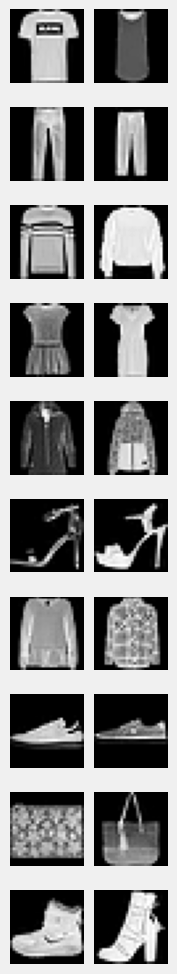

In [67]:
# Parameters to retrieve the best model
hyperparameters = Params(num_epochs=500, learning_rate=0.0005, batch_size=200, max_early_stop=50)
model_name = f"{FashionCNN().__class__.__name__}__lr{hyperparameters.learning_rate}_batch{hyperparameters.batch_size}_epoch{hyperparameters.num_epochs}_earlystop{hyperparameters.max_early_stop}"
model_save_path = os.path.join(root_dir, f"PyTorch_models/{model_name}")

# Load the best model
fashion_cnn_final = load_torch_model(FashionCNN(), model_save_path)
# Get Convolution layers from the model
conv_layers, conv_layers_weights = get_conv_layers(fashion_cnn_final)

# Sample images from training set
sampled_images = sample_images_for_each_class(train_set, sample_size=2)

### 4.3.7.2 Visualization of Filters for the Two Convolution Layers in FashionCNN

1-th Conv Layer:


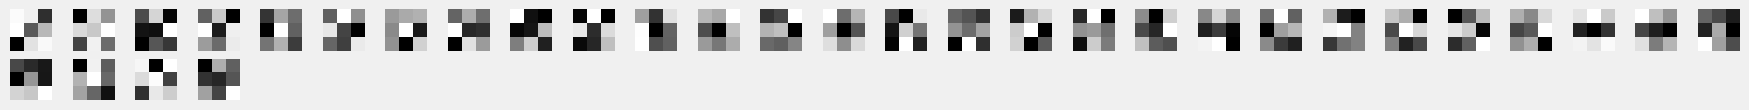

2-th Conv Layer:


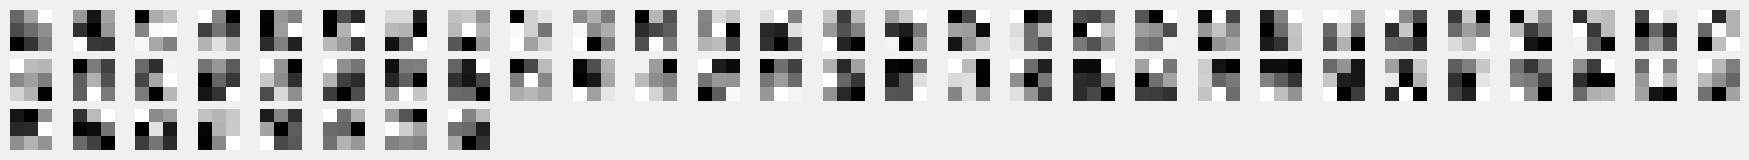

In [68]:
for i, weight in enumerate(conv_layers_weights, start=1):
    print(f"{i}-th Conv Layer:")
    plot_filters(weight)

### 4.3.7.3 Visualization of Feature Maps for the Two Convolution Layers in FashionCNN

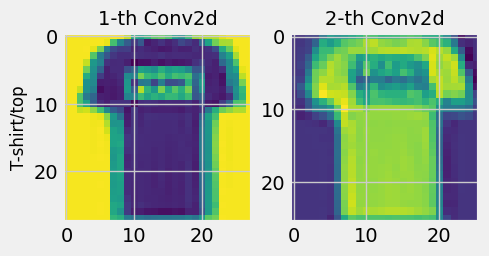

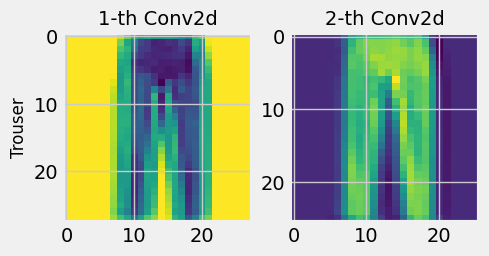

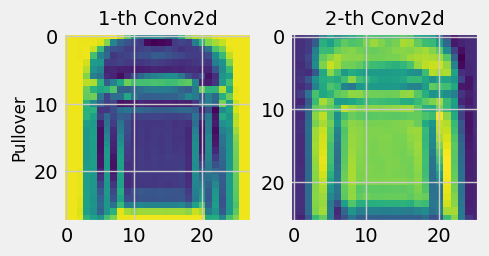

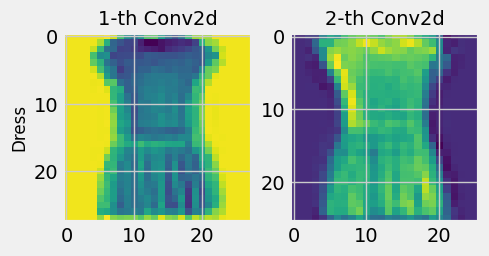

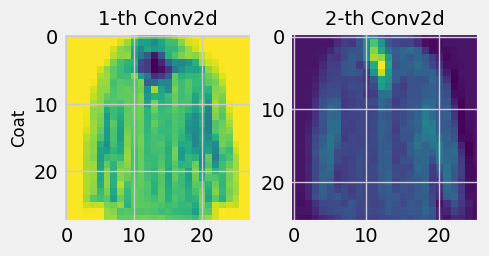

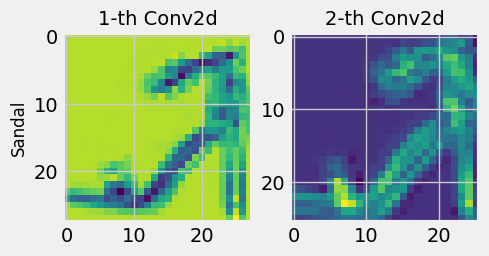

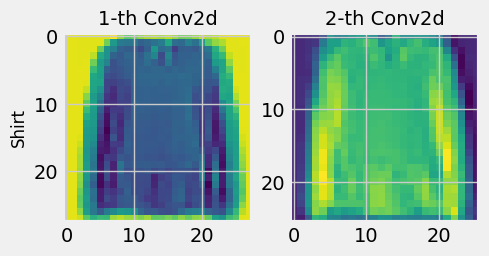

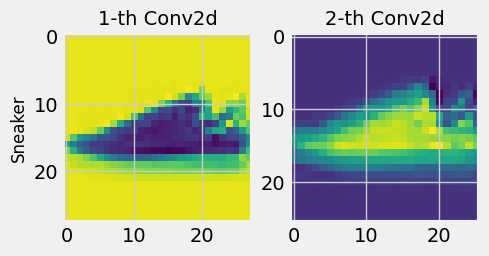

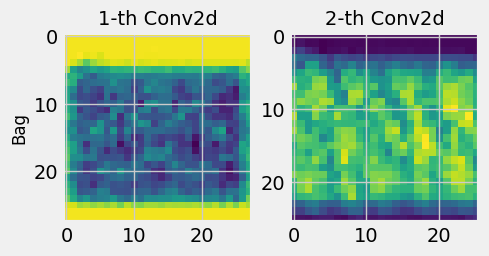

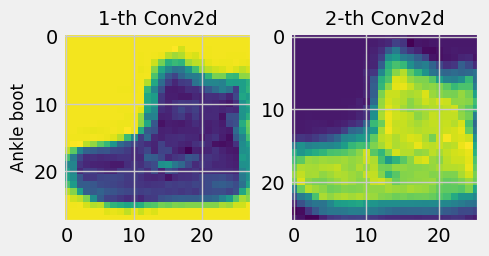

<Figure size 640x480 with 0 Axes>

In [73]:
for label in range(10):
    image = sampled_images[label][0].unsqueeze(0) # Add a batch dimension
    feature_maps, layer_names = get_feature_maps(image, conv_layers)
    # plot_feature_maps(feature_maps, layer_names, labels_map)
    fig = plt.figure(figsize=(10, 20))
    for i, (feature_map, layer_name) in enumerate(zip(feature_maps, layer_names), start=0):
        a = fig.add_subplot(5, 4, i+1)
        imgplot = plt.imshow(feature_map)
        # a.axis("off")
        _ = a.set_title(f"{i+1}-th {layer_name.split('(')[0]}", fontsize=14)
        if i == 0:
            _ = a.set_ylabel(f"{labels_map[label]}", fontsize=12)
plt.show()
plt.tight_layout();

# 5. Conclusion

According to PCA and t-SNE, we discovered that the data has nonlinearity. Therefore, our study compared three nonlinear models—XGBoost, Random Forests, and FashionCNN—for FashionMNIST classification. FashionCNN excelled in capturing intricate patterns in images and achieved the best classification results, an accuracy of 92.16%. Random Forests and XGBoost, on the other hand, were ineffective in modeling nonlinear relationships within the data.